
## Final Team Project: Music Genre and Composer Classification Using Deep Learning

### Date: 08/07/2025

### Contributions : 

Swathi Subramanyam Pabbathi (LSTM and BilSTM) ,
 
Omar Sagoo (CNN implementations) and

Carlos Ortiz  (Reporting and ReadMe)



This notebook includes data preparation, exploratory data analysis (EDA), data preprocessing, feature extraction, and the implementation of multiple deep learning models: LSTM and Bidirectional LSTM with Attention and CNN.

For each model, we performed model building, training, evaluation, and hyperparameter tuning using grid search to identify the optimal configuration. The final versions of the models were saved as:

*	final_lstm_model.keras

*	final_bi_lstm_attention_model.keras

*   cnn_piano_roll.keras



featured datasets train, val and test for further analysis and testing are placed in featured_datasets folder /featured_datasets

Requirements: 

We used an AWS SageMaker ml.g4dn.xlarge instance to train and fine-tune the LSTM and Bidirectional LSTM + Attention models. The workspace required approximately 20 GB of storage for managing the MIDI dataset, processed feature files, and model checkpoints during training and evaluation.

Using Google Colab for this notebook in CNN implementation in order to utilize TPUs, We must pip install the dependencies that are not included, like the tensorflow tpu package and `pretty_midi`.


Github link : https://github.com/PSswathi/music-genre-and-composer-classification/tree/main

#### Github Project Structure

```plaintext
MUSIC-GENRE-AND-COMPOSER-CLASSIFICATION/
│
├── featured datasets/                  # Datasets used for training & evaluation
│   ├── data_splits.npz                  # Preprocessed train/val/test splits
│   └── datasets.zip                     # Raw MIDI dataset archive
│
├── models/                              # Saved trained model weights
│   ├── cnn_piano_roll.keras              # Final CNN model (piano roll input)
│   ├── final_bi_lstm_attention_model.keras # Final BiLSTM + Attention model
│   └── final_lstm_model.keras            # Final LSTM model
│
├── notebooks/                           # Jupyter notebooks for experiments
│   ├── helpers/
│   │   └── processor.py                  # Preprocessing utilities (feature extraction, augmentation)
│   ├── cnn_piano_roll.ipynb              # CNN training & evaluation pipeline
│   └── notelevel-lstm-bilstm-attn-swathi.ipynb  # LSTM & BiLSTM + Attention training & evaluation
│
├── proposal/                            # Project proposal & documentation
│   └── AAI-511-group6 Final Team Project Status Update For…pdf
│
├── selectedcomposers/                   # Selected composer MIDI datasets
│   ├── Bach/
│   ├── Beethoven/
│   ├── Chopin/
│   └── Mozart/
│
├── merged-compared-lstm-bilstm-cnn.ipynb # Combined metrics & comparison notebook
│
├── environment.yml                      # Conda environment file with dependencies
├── Makefile                              # Automation commands (optional build/run targets)
├── README.md                             # Project documentation (this file)
└── .gitignore                            # Ignored files for Git
```

Since this project involves extensive model training and hyperparameter tuning on AWS SageMaker to improvise the performances, I included the following configurations to suppress non-critical warnings and control TensorFlow device behavior. This ensures cleaner logs, reduces unnecessary output during training, and prevents deprecated library messages from cluttering evaluation results.

In [6]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API*",
    category=UserWarning,
    module=r"pretty_midi\.instrument"
)

import os
from collections import defaultdict
import pandas as pd
import pretty_midi

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, force CPU

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPUs: []


### Import all the necessary libraries

In [5]:
# importing all necessary libraries
import numpy as np
np.int = int 
import zipfile
import io
import pretty_midi
import pkg_resources
import os
import warnings
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tempfile
import pygame
import math
from tqdm import tqdm

# tensorflow libraries
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Data loading and preparation

In [1]:
from glob import glob
import os

root_dir = "../selectedcomposers"
composer_to_files = {
    composer: glob(os.path.join(root_dir, composer, "**", "*.mid"), recursive=True)
    for composer in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, composer))
}

for composer, files in composer_to_files.items():
    print(f"{composer}: {len(files)} files")

Mozart: 257 files
Chopin: 136 files
Beethoven: 211 files
Bach: 925 files


### Train, Val and Test data split

I wanted to split the train, val and test before feature extraction to avoid any data leakage while extracting global features on composer+file+program level not only on chunk level and frequency encode on features such as program(i.e.,instrument type)

### Data preparation steps included note level and higher-level statistics on chunk level to extract featured in structured data ,

1.	Split dataset – MIDI files are grouped by composer and split into train (70%), validation (15%), and test (15%) sets, skipping composers with fewer than 3 files.

2.	Filter valid composers – Only Bach, Beethoven, Chopin, Mozart are included, each mapped to a numeric class ID.

3.	Feature extraction per file –
    *	Ignore drum tracks and sort notes by start time.
    *	Process non-overlapping chunks of 200 notes.

4.	Higher-level statistics (per chunk) – Compute pitch range, note density, repetition rate, average interval, rhythmic variety, chord density, and tempo.

5.	Per-note features – Extract pitch, duration, velocity, delta time, interval, instrument program, accent flag, and timing details.

6.	File processing & tracking – Count how many files are successfully processed vs. skipped (too short or parse errors).

7.	Output DataFrames – Create separate Pandas DataFrames for train (df_train), validation (df_val), and test (df_test) containing all extracted features for model input.

In [ ]:
# Split each composer’s MIDI files into train/val/test
from sklearn.model_selection import train_test_split

train_files, val_files, test_files = [], [], []

for composer, files in composer_to_files.items():
    if len(files) < 3:
        print(f"Skipping {composer} — not enough files: {len(files)}")
        continue  # Skip this composer

    # 70% train, 15% val, 15% test
    train, temp = train_test_split(files, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    train_files.extend(train)
    val_files.extend(val)
    test_files.extend(test)

print(f"# Train MIDI files: {len(train_files)}")
print(f"# Val MIDI files: {len(val_files)}")
print(f"# Test MIDI files: {len(test_files)}")

# Train MIDI files: 1068
# Val MIDI files: 230
# Test MIDI files: 231


### Label encoding the target variale to 0, 1, 2 and 3 rather than text

In [3]:
# Map composers to numeric class IDs
# Filter only valid composers
VALID_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

composer_list = VALID_COMPOSERS  # Already filtered
composer_to_id = {name: idx for idx, name in enumerate(composer_list)}

print("\n Composers:", composer_list)
print("Composer to ID mapping:", composer_to_id)


 Composers: ['Bach', 'Beethoven', 'Chopin', 'Mozart']
Composer to ID mapping: {'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Mozart': 3}


### Note level feature extraction 

Below are the features extracted for the classification task on composers,

The function extract_note_features() is designed to extract structured features from MIDI files for use in machine learning tasks such as composer classification.

1.	Tempo Extraction: The function estimates the overall tempo of the MIDI file.

2.	Instrument Loop:Iterates through all non-drum instruments in the MIDI file.

3.	Note Sorting and Chunking:Sorts notes by start time and breaks them into non-overlapping chunks of a given size (default: 200 notes).

4.	Chunk-Level Feature Calculation:For each chunk, it computes aggregate musical features that describe the overall structure and behavior of the notes in that chunk.

5.	Per-Note Feature Extraction:For each note in a chunk, it extracts time-based and pitch-based features and annotates them with the chunk-level statistics.

6.	Feature Aggregation:The result is a list of dictionaries, each representing a single note with both per-note and chunk-level musical attributes, along with composer metadata.


| Feature           | Description                                                                 |
|-------------------|-----------------------------------------------------------------------------|
| `Pitch`           | The MIDI pitch number (0–127) of the note.                                  |
| `Duration`        | The time the note is held (end time - start time).                          |
| `Velocity`        | The intensity/loudness of the note (0–127).                                 |
| `DeltaTime`       | Time difference between the current and previous note's start time.         |
| `Start`           | Start time of the note in seconds.                                          |
| `End`             | End time of the note in seconds.                                            |
| `Interval`        | Difference in pitch from the previous note.                                 |
| `Program`         | MIDI program number representing the instrument used.                       |
| `Accented`        | Binary flag indicating whether the note is played loudly (velocity > 80).   |
| `Composer`        | The name of the composer associated with the MIDI file.                     |
| `ComposerID`      | Numeric class ID for the composer (used for classification).                |
| `Tempo`           | Estimated global tempo (beats per minute) of the MIDI file.                 |
| `PitchRange`      | Difference between the highest and lowest pitch in the note chunk.          |
| `NoteDensity`     | Number of notes per second within the chunk.                                |
| `RepetitionRate`  | Proportion of notes that have the same pitch as their immediate predecessor.|
| `AvgInterval`     | Average pitch interval between consecutive notes in the chunk.              |
| `RhythmicVariety` | Standard deviation of note durations in the chunk (indicates rhythm complexity). |
| `ChordDensity`    | Fraction of notes that overlap with the previous note (indicates harmony/chords). |



In [4]:
def extract_note_features(midi, composer, composer_id, chunk_size=200):
    features = []

    # Extract global tempo
    try:
        tempo = midi.estimate_tempo()
    except:
        tempo = 120.0  # fallback tempo

    for instrument in midi.instruments:
        if instrument.is_drum:
            continue
        instrument_program = instrument.program
        notes = sorted(instrument.notes, key=lambda n: n.start)

        if len(notes) < chunk_size:
            continue  # skip short instruments

        # Chunk the notes (non-overlapping)
        for i in range(0, len(notes) - chunk_size + 1, chunk_size):
            chunk = notes[i:i+chunk_size]
            chunk_start = chunk[0].start
            chunk_end = chunk[-1].end
            chunk_duration = chunk_end - chunk_start

            # ---- Higher-level stats ----
            pitches = [n.pitch for n in chunk]
            durations = [n.end - n.start for n in chunk]
            velocities = [n.velocity for n in chunk]
            intervals = [pitches[i] - pitches[i-1] for i in range(1, len(pitches))]
            starts = [n.start for n in chunk]

            pitch_range = max(pitches) - min(pitches)
            note_density = len(chunk) / (chunk_duration + 1e-6)  # notes/sec
            repetition_rate = sum([1 for i in range(1, len(pitches)) if pitches[i] == pitches[i-1]]) / len(pitches)
            avg_interval = np.mean(intervals) if intervals else 0.0
            rhythmic_variety = np.std(durations)
            chord_density = sum([1 for i in range(1, len(chunk)) if chunk[i].start < chunk[i-1].end]) / len(chunk)

            # ---- Per-note features ----
            prev_start = chunk[0].start
            prev_pitch = chunk[0].pitch

            for note in chunk:
                pitch = note.pitch
                start = note.start
                end = note.end
                duration = end - start
                delta_time = start - prev_start
                velocity = note.velocity
                interval = pitch - prev_pitch
                is_accented = 1 if velocity > 80 else 0

                features.append({
                    "Pitch": pitch,
                    "Duration": duration,
                    "Velocity": velocity,
                    "DeltaTime": delta_time,
                    "Start": start,
                    "End": end,
                    "Interval": interval,
                    "Program": instrument_program,
                    "Accented": is_accented,
                    "Composer": composer,
                    "ComposerID": composer_id,
                    "Tempo": tempo,
                    "PitchRange": pitch_range,
                    "NoteDensity": note_density,
                    "RepetitionRate": repetition_rate,
                    "AvgInterval": avg_interval,
                    "RhythmicVariety": rhythmic_variety,
                    "ChordDensity": chord_density
                })

                prev_start = start
                prev_pitch = pitch

    return features

Takes a list of midi_files, a composer_to_id dictionary mapping composer names to numeric IDs, and an optional chunk_size (default = 200 notes). Returns a DataFrame with engineered features extracted from each MIDI file.

In [11]:
import warnings
import os
from collections import defaultdict
import pandas as pd
import pretty_midi

def extract_features_from_files(midi_files, composer_to_id, chunk_size=200):
    all_features = []
    skipped_counts = defaultdict(int)  # Track skips per composer
    used_counts = defaultdict(int)     # track used files 

    for path in midi_files:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                midi = pretty_midi.PrettyMIDI(path)

            composer = os.path.basename(os.path.dirname(path))
            composer_id = composer_to_id[composer]

            feats = extract_note_features(midi, composer, composer_id, chunk_size)

            if feats:  # Only add if there are extracted features
                all_features.extend(feats)
                used_counts[composer] += 1
            else:
                skipped_counts[composer] += 1  # Track skipped

        except Exception:
            # Could optionally also track parse errors
            skipped_counts[composer] += 1  # Parsing error also counts as skipped

    # Print summary
    print("\n Feature Extraction Summary by Composer:")
    all_composers = set(composer_to_id.keys())
    for composer in sorted(all_composers):
        skipped = skipped_counts[composer]
        used = used_counts[composer]
        total = skipped + used
        print(f"{composer}: Skipped {skipped} / {total} files ({used} used)")

    return pd.DataFrame(all_features)

In [ ]:
# Extract the features separately on all train,val and test datasets
df_train = extract_features_from_files(train_files, composer_to_id, chunk_size=200)
df_val   = extract_features_from_files(val_files, composer_to_id, chunk_size=200)
df_test  = extract_features_from_files(test_files, composer_to_id, chunk_size=200)


 Feature Extraction Summary by Composer:
Bach: Skipped 3 / 83 files (80 used)
Beethoven: Skipped 8 / 93 files (85 used)
Chopin: Skipped 2 / 95 files (93 used)
Mozart: Skipped 3 / 65 files (62 used)

 Feature Extraction Summary by Composer:
Bach: Skipped 0 / 17 files (17 used)
Beethoven: Skipped 0 / 16 files (16 used)
Chopin: Skipped 1 / 20 files (19 used)
Mozart: Skipped 0 / 13 files (13 used)

 Feature Extraction Summary by Composer:
Bach: Skipped 0 / 22 files (22 used)
Beethoven: Skipped 2 / 23 files (21 used)
Chopin: Skipped 1 / 21 files (20 used)
Mozart: Skipped 0 / 12 files (12 used)


In [13]:
import os

# Define the output folder path (one level up from notebook)
output_dir = os.path.join("..", "featured_datasets")

# Create the folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the files in the specified folder
df_train.to_csv(os.path.join(output_dir, "composer_train_features.csv"), index=False)
df_val.to_csv(os.path.join(output_dir, "composer_val_features.csv"), index=False)
df_test.to_csv(os.path.join(output_dir, "composer_test_features.csv"), index=False)

print("CSV files saved to:", output_dir)

CSV files saved to: ../featured_datasets


In [14]:
# Drop only the 'Composer' column from original datasets
df_train.drop(columns=['Composer'], inplace=True, errors='ignore')
df_val.drop(columns=['Composer'], inplace=True, errors='ignore')
df_test.drop(columns=['Composer'], inplace=True, errors='ignore')

# Show sample rows
print("Train Set Sample:")
display(df_train.head())

print("Validation Set Sample:")
display(df_val.head())

print("Test Set Sample:")
display(df_test.head())

Train Set Sample:


,Pitch,Duration,Velocity,DeltaTime,Start,End,Interval,Program,Accented,ComposerID,Tempo,PitchRange,NoteDensity,RepetitionRate,AvgInterval,RhythmicVariety,ChordDensity
0,76,0.400000,103,0.000000,0.000000,0.400000,0,0,1,3,162.571658,31,3.143453,0.07,-0.025126,0.63221,0.65
1,72,0.444444,103,0.000000,0.000000,0.444444,-4,0,1,3,162.571658,31,3.143453,0.07,-0.025126,0.63221,0.65
2,64,0.444444,103,0.000000,0.000000,0.444444,-8,0,1,3,162.571658,31,3.143453,0.07,-0.025126,0.63221,0.65
3,76,1.055555,93,0.666666,0.666666,1.722222,12,0,1,3,162.571658,31,3.143453,0.07,-0.025126,0.63221,0.65
4,72,1.077778,103,0.000000,0.666666,1.744444,-4,0,1,3,162.571658,31,3.143453,0.07,-0.025126,0.63221,0.65


Validation Set Sample:


,Pitch,Duration,Velocity,DeltaTime,Start,End,Interval,Program,Accented,ComposerID,Tempo,PitchRange,NoteDensity,RepetitionRate,AvgInterval,RhythmicVariety,ChordDensity
0,60,0.910714,84,0.000000,0.003571,0.914286,0,48,1,3,128.592571,24,3.037288,0.035,0.070352,0.705369,0.875
1,79,2.442858,84,0.000000,0.003571,2.446429,19,48,1,3,128.592571,24,3.037288,0.035,0.070352,0.705369,0.875
2,76,2.446429,84,0.000000,0.003571,2.450000,-3,48,1,3,128.592571,24,3.037288,0.035,0.070352,0.705369,0.875
3,64,0.914286,84,0.853572,0.857143,1.771429,-12,48,1,3,128.592571,24,3.037288,0.035,0.070352,0.705369,0.875
4,67,0.919643,84,0.857143,1.714286,2.633929,3,48,1,3,128.592571,24,3.037288,0.035,0.070352,0.705369,0.875


Test Set Sample:


,Pitch,Duration,Velocity,DeltaTime,Start,End,Interval,Program,Accented,ComposerID,Tempo,PitchRange,NoteDensity,RepetitionRate,AvgInterval,RhythmicVariety,ChordDensity
0,69,2.39,48,0.0,6.0,8.39,0,71,0,3,217.365093,22,1.122397,0.03,0.0,0.653103,0.37
1,68,1.19,48,2.4,8.4,9.59,-1,71,0,3,217.365093,22,1.122397,0.03,0.0,0.653103,0.37
2,69,1.19,48,1.2,9.6,10.79,1,71,0,3,217.365093,22,1.122397,0.03,0.0,0.653103,0.37
3,71,1.19,48,1.2,10.8,11.99,2,71,0,3,217.365093,22,1.122397,0.03,0.0,0.653103,0.37
4,72,1.19,48,1.2,12.0,13.19,1,71,0,3,217.365093,22,1.122397,0.03,0.0,0.653103,0.37


In [15]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1095200, 17)
(169200, 17)
(214200, 17)


### Exploratory Data Analysis

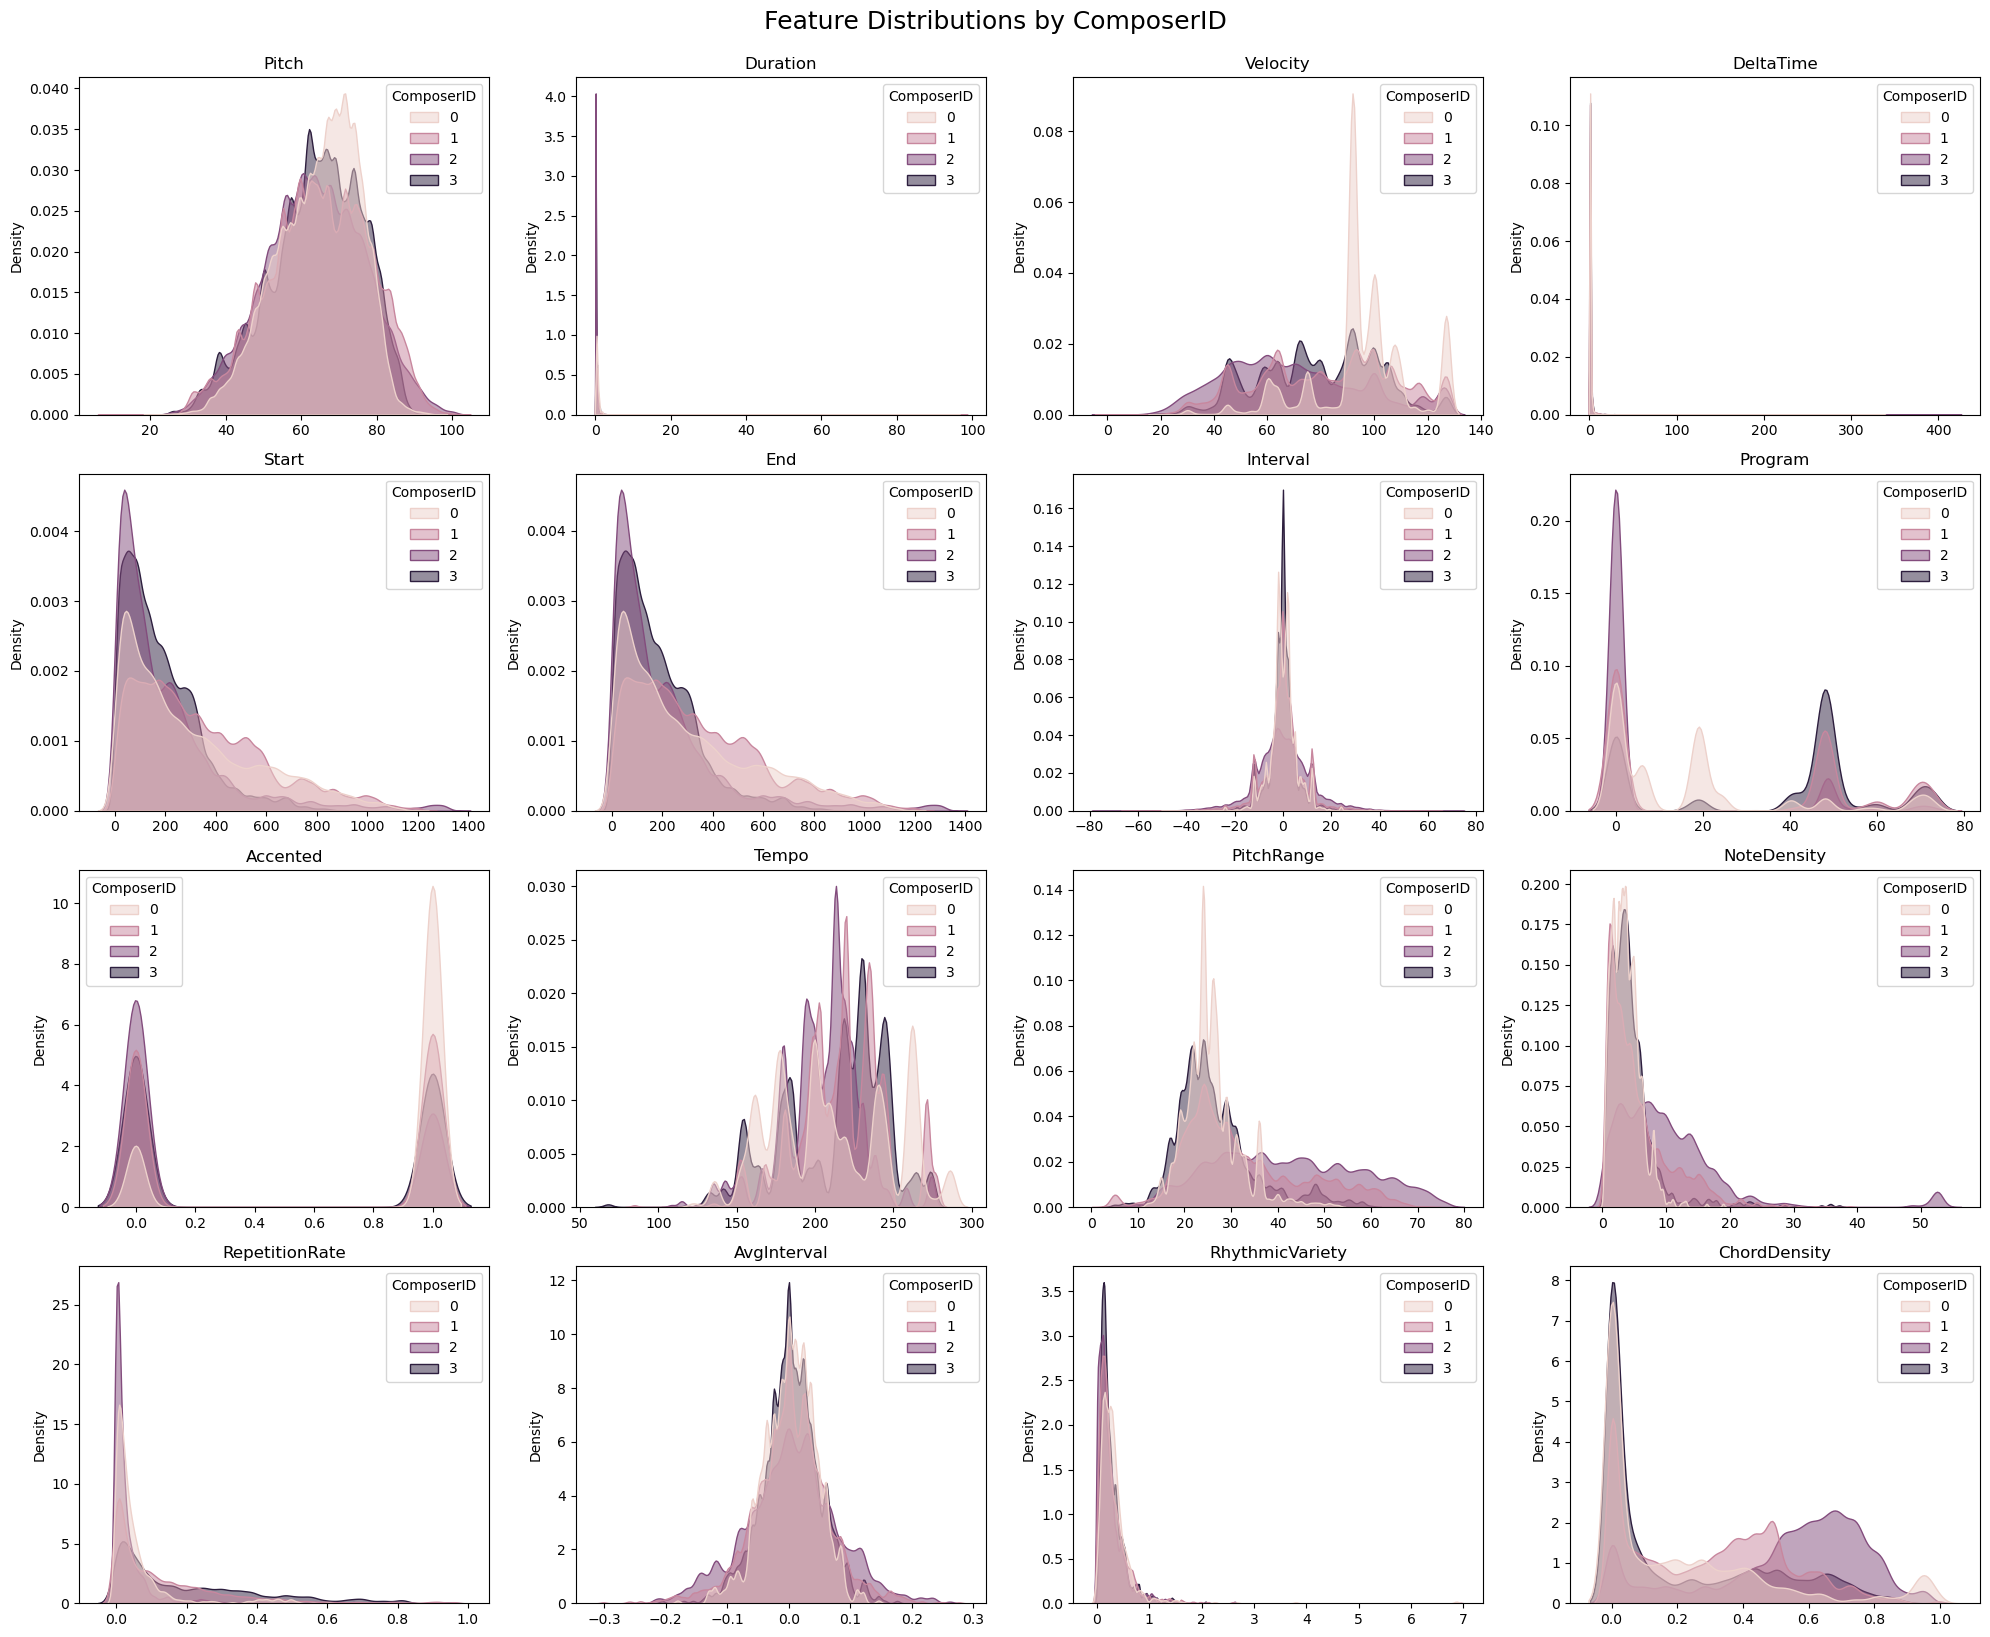

In [16]:
# To plot all features distributions by ComposerID
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns excluding 'ComposerID'
feature_cols = [col for col in df_train.columns if col != 'ComposerID' and df_train[col].dtype != 'object']

# Set up the grid
n_cols = 4
n_rows = (len(feature_cols) + n_cols - 1) // n_cols  # ceiling division

plt.figure(figsize=(20, 4 * n_rows))

for idx, col in enumerate(feature_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.kdeplot(data=df_train, x=col, hue="ComposerID", common_norm=False, fill=True, alpha=0.5)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Density')

plt.tight_layout()
plt.suptitle("Feature Distributions by ComposerID", fontsize=18, y=1.02)
plt.show()

### Feature Distribution Inference by Composer

| Feature        | Inference |
|----------------|-----------|
| **Pitch**      | All composers use pitch ranges ~40–80. **Mozart (3)** leans toward slightly higher pitch centers, while **Bach (0)** and **Beethoven (1)** are more balanced. |
| **Duration**   | All show a sharp peak at very short durations (~0–5), but **Chopin (2)** has a slightly longer tail, consistent with his sustained, expressive style. |
| **Velocity**   | **Mozart (3)** has a strong peak near 80 (consistent dynamics), while **Chopin (2)** and **Beethoven (1)** have broader variation in note velocity. |
| **DeltaTime**  | Sharp spike near zero for all, indicating frequent note events. **Bach (0)** shows a denser concentration at low delta times, suggesting tighter rhythmic structure. |
| **Start / End**| All have right-skewed distributions; **Mozart (3)** and **Beethoven (1)** extend further, possibly due to longer or more complex compositions. |
| **Interval**   | All peak strongly at 0 (step-wise motion), but **Bach (0)** and **Beethoven (1)** maintain tighter interval ranges, while **Mozart (3)** and **Chopin (2)** have slightly more leaps. |
| **Program**    | **Bach (0)** clusters in low program numbers (keyboard instruments), **Mozart (3)** and **Chopin (2)** use a wider range, **Beethoven (1)** is moderately varied. |
| **Accented**   | **Mozart (3)** and **Chopin (2)** show higher density near 1.0, indicating more accented notes; **Bach (0)** has fewer accents. |
| **Tempo**      | **Chopin (2)** has a broad spread (rubato), **Mozart (3)** also varies but peaks around 200–250, **Bach (0)** and **Beethoven (1)** are more consistent. |
| **PitchRange** | **Mozart (3)** uses a wider pitch range; **Bach (0)** and **Beethoven (1)** keep tighter ranges; **Chopin (2)** shows moderate variation. |
| **NoteDensity**| **Chopin (2)** has lower density (more space between notes); **Bach (0)** and **Beethoven (1)** show higher density; **Mozart (3)** is in between. |
| **RepetitionRate** | All show a strong peak near 0.0 (low repetition per note), but **Bach (0)** is slightly higher in very low values, indicating more unique note sequences. |
| **AvgInterval** | All cluster near 0, but **Mozart (3)** and **Chopin (2)** have slightly broader spread, indicating more varied melodic leaps. |
| **RhythmicVariety** | Strong peak near 1.0 for all, but **Bach (0)** slightly lower spread, reflecting structured rhythm; **Chopin (2)** and **Mozart (3)** have more variety. |
| **ChordDensity** | **Mozart (3)** and **Chopin (2)** lean toward higher chord density, **Bach (0)** has moderate density, **Beethoven (1)** varies between low and medium. |

**Stylistic Notes:**

- **Mozart (3):** Broad pitch range, frequent accents, wider intervals, varied tempo, and higher chord density.
- **Chopin (2):** Longer durations, expressive tempo shifts, fewer notes per unit time, frequent accents, and moderate chord density.
- **Bach (0):** Tight rhythmic structure, high note density, narrower pitch and interval range, fewer accents—consistent with contrapuntal style.
- **Beethoven (1):** Balanced between classical and romantic styles—moderate note density, wider compositions, and varied dynamics.

Class distribution in train dataset:
ComposerID
1    466600
3    220600
0    208000
2    200000
Name: count, dtype: int64


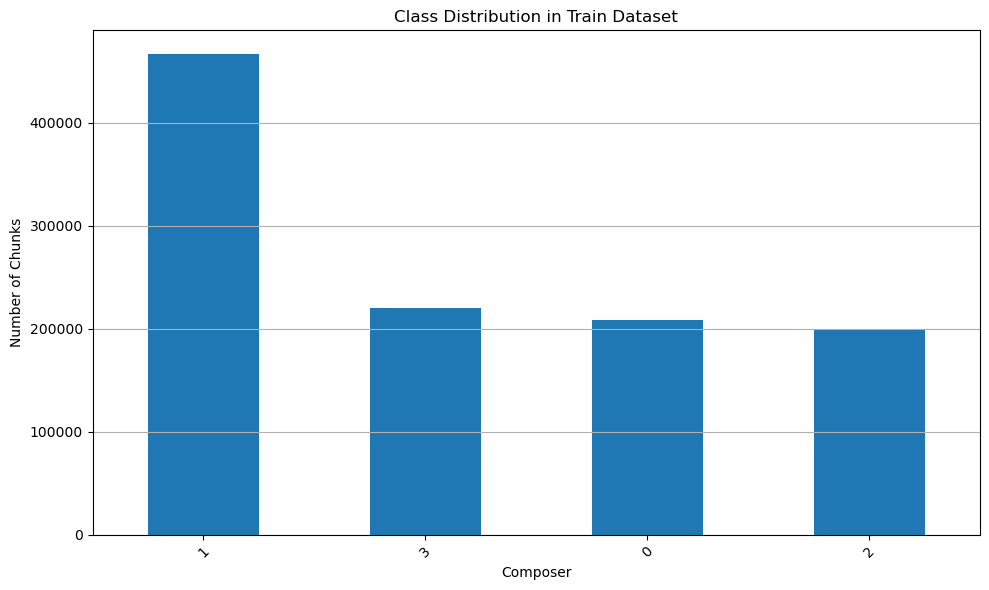

In [17]:
# Class distribution in train dataset
composer_counts = df_train['ComposerID'].value_counts()
print("Class distribution in train dataset:")
print(composer_counts)

# Optional: visualize it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
composer_counts.plot(kind='bar')
plt.title('Class Distribution in Train Dataset')
plt.xlabel('Composer')
plt.ylabel('Number of Chunks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Observations**

1.	Composer “1” has the largest number of chunks (~470k) — more than double the chunks of any other composer.
2.	Composers “0”, “2”, and “3” have a much smaller and roughly similar number of chunks (~200k–220k).
3.	This imbalance means the model will see Composer 1 much more often during training, making it easier for the model to learn patterns for Composer 1 but harder to correctly identify the other composers.

**Impact on Model Performance**

1.	Bias toward majority class: The model might predict “Composer 1” more often because it learns those patterns best.
2.	Lower recall/precision for minority classes: Even if the model has high overall accuracy, the smaller classes may be misclassified more often.
3.	Poor generalization: The imbalance can cause the model to overfit to the dominant class.

**Possible Solutions**

1.	Undersampling: Reduce Composer 1’s samples to match other composers’ levels (risk: losing potentially useful data).
2.	Oversampling: Duplicate or augment data for minority classes (risk: overfitting if duplicating).
3.	Data augmentation: Use pitch shifting, time stretching, or note transposition to synthetically expand minority classes.
4.	Class weighting: Assign higher weights to minority classes during loss calculation so the model treats their errors more seriously.

In [ ]:
# Frequency of 'Program' in the training set
program_freq = df_train['Program'].value_counts(normalize=True)

# Convert to a dictionary
program_freq_dict = program_freq.to_dict()

### Data Preprocessing - perform Note-Level Data Augmentation (on df_train only)

In [19]:
# Get class counts
train_counts = df_train['ComposerID'].value_counts()
target_count = train_counts.max()

# Define augmentation function (on a group of notes)
def augment_notes(notes_df):
    df_aug = notes_df.copy()

    # Random parameters
    pitch_shift = np.random.choice([-3, -2, -1, 1, 2, 3])
    duration_scale = np.random.uniform(0.9, 1.1)
    time_shift = np.random.uniform(-0.1, 0.1)

    df_aug['Pitch'] = np.clip(df_aug['Pitch'] + pitch_shift, 0, 127)
    df_aug['Duration'] = df_aug['Duration'] * duration_scale
    df_aug['Start'] = df_aug['Start'] + time_shift
    df_aug['End'] = df_aug['Start'] + df_aug['Duration']
    
    return df_aug


In [20]:
from sklearn.utils import resample

target_count = df_train['ComposerID'].value_counts().max()
balanced_chunks = []

for composer in df_train['ComposerID'].unique():
    df_c = df_train[df_train['ComposerID'] == composer]
    current_count = len(df_c)
    
    if current_count < target_count:
        needed = target_count - current_count
        # Create note chunks
        note_chunks = [df_c.iloc[i:i+200] for i in range(0, len(df_c)-200, 200)]
        
        for _ in range(needed // 200):
            chunk = resample(note_chunks, n_samples=1)[0]
            augmented = augment_notes(chunk)
            balanced_chunks.append(augmented)

df_train_aug = pd.concat([df_train] + balanced_chunks).reset_index(drop=True)

<Axes: xlabel='ComposerID'>

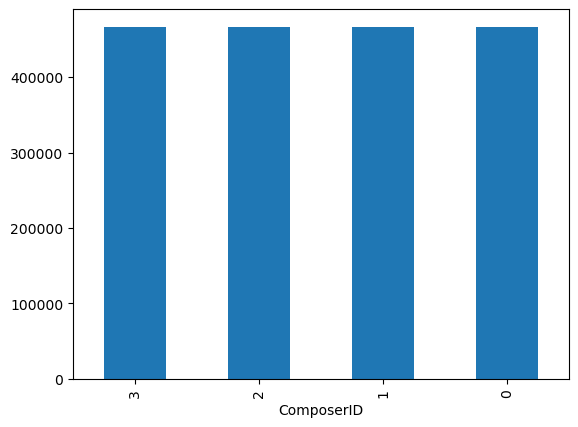

In [21]:
df_train_aug['ComposerID'].value_counts().plot(kind='bar')

After data augmentation and resampling underdetermined classes to balance the data on train dataset

In [22]:
df_train['Source'] = 'Original'

# Label each augmented chunk
for chunk in balanced_chunks:
    chunk['Source'] = 'Augmented'

# Combine all augmented chunks
df_augmented = pd.concat(balanced_chunks).reset_index(drop=True)

# Merge for comparison
df_compare = pd.concat([df_train, df_augmented]).reset_index(drop=True)

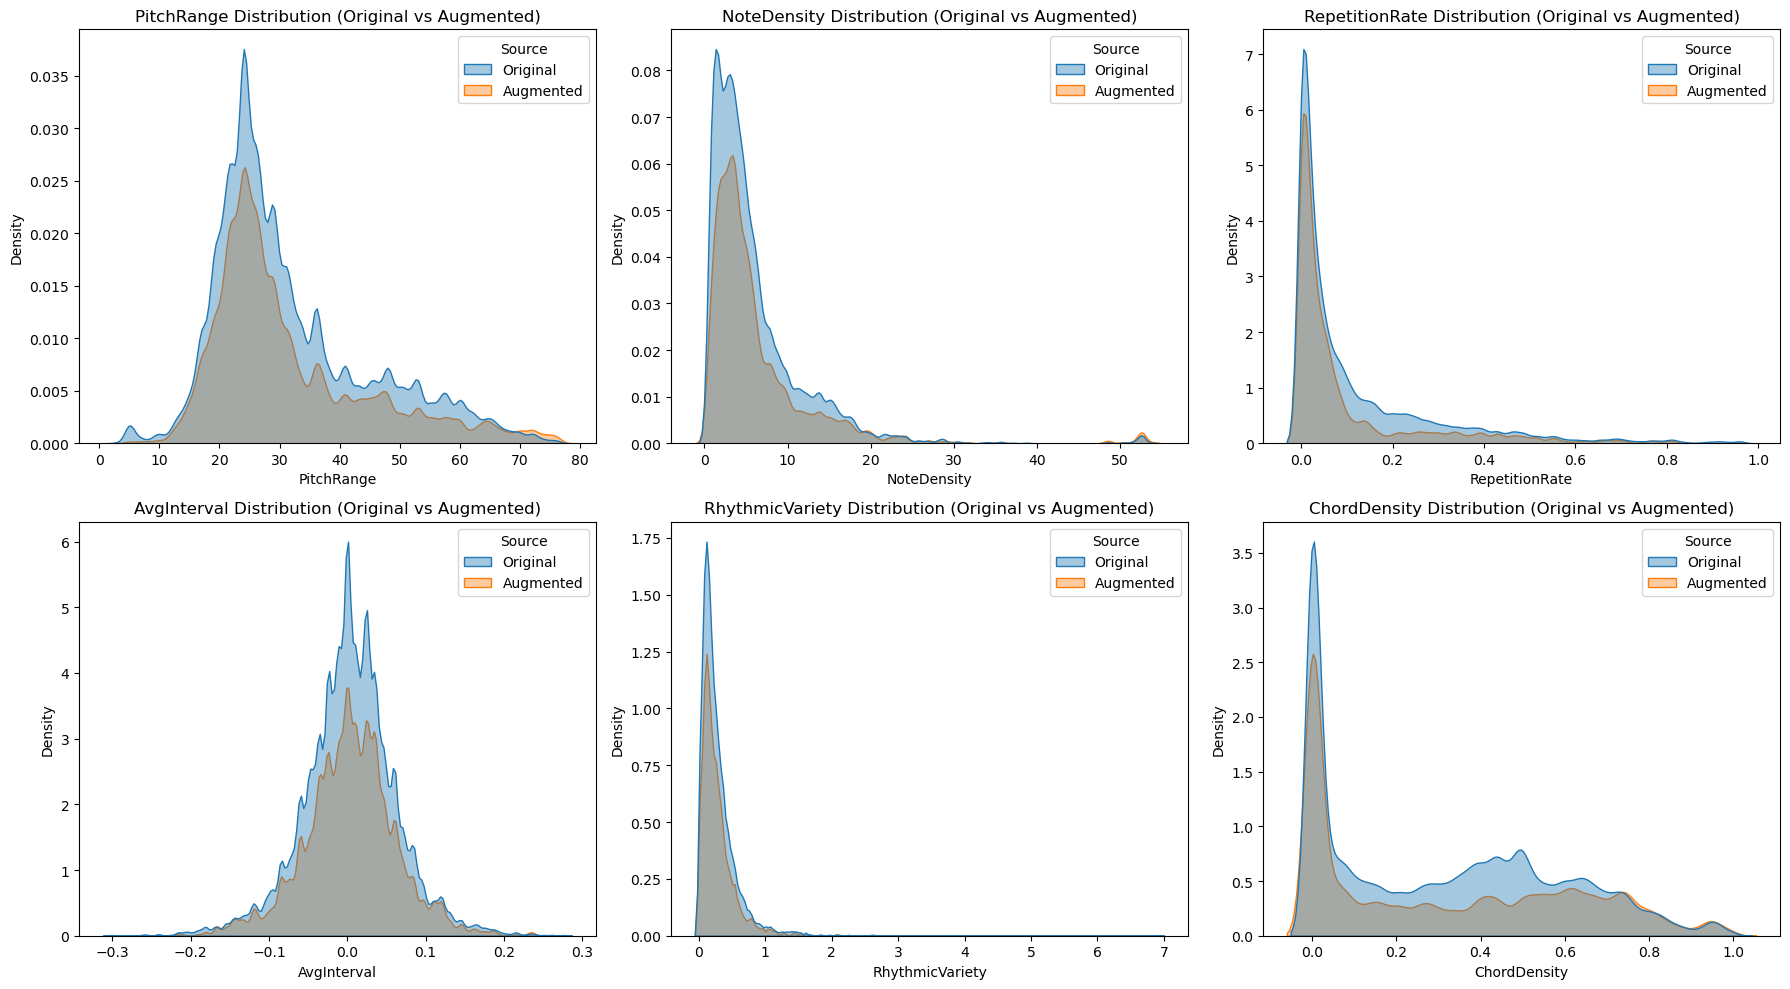

In [23]:
# Plots to compare original and after augmentations
import seaborn as sns
import matplotlib.pyplot as plt

features = ['PitchRange', 'NoteDensity', 'RepetitionRate', 'AvgInterval', 'RhythmicVariety', 'ChordDensity']

plt.figure(figsize=(18, 10))
for i, feat in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(data=df_compare, x=feat, hue='Source', fill=True, alpha=0.4)
    plt.title(f'{feat} Distribution (Original vs Augmented)')

plt.tight_layout()
plt.show()

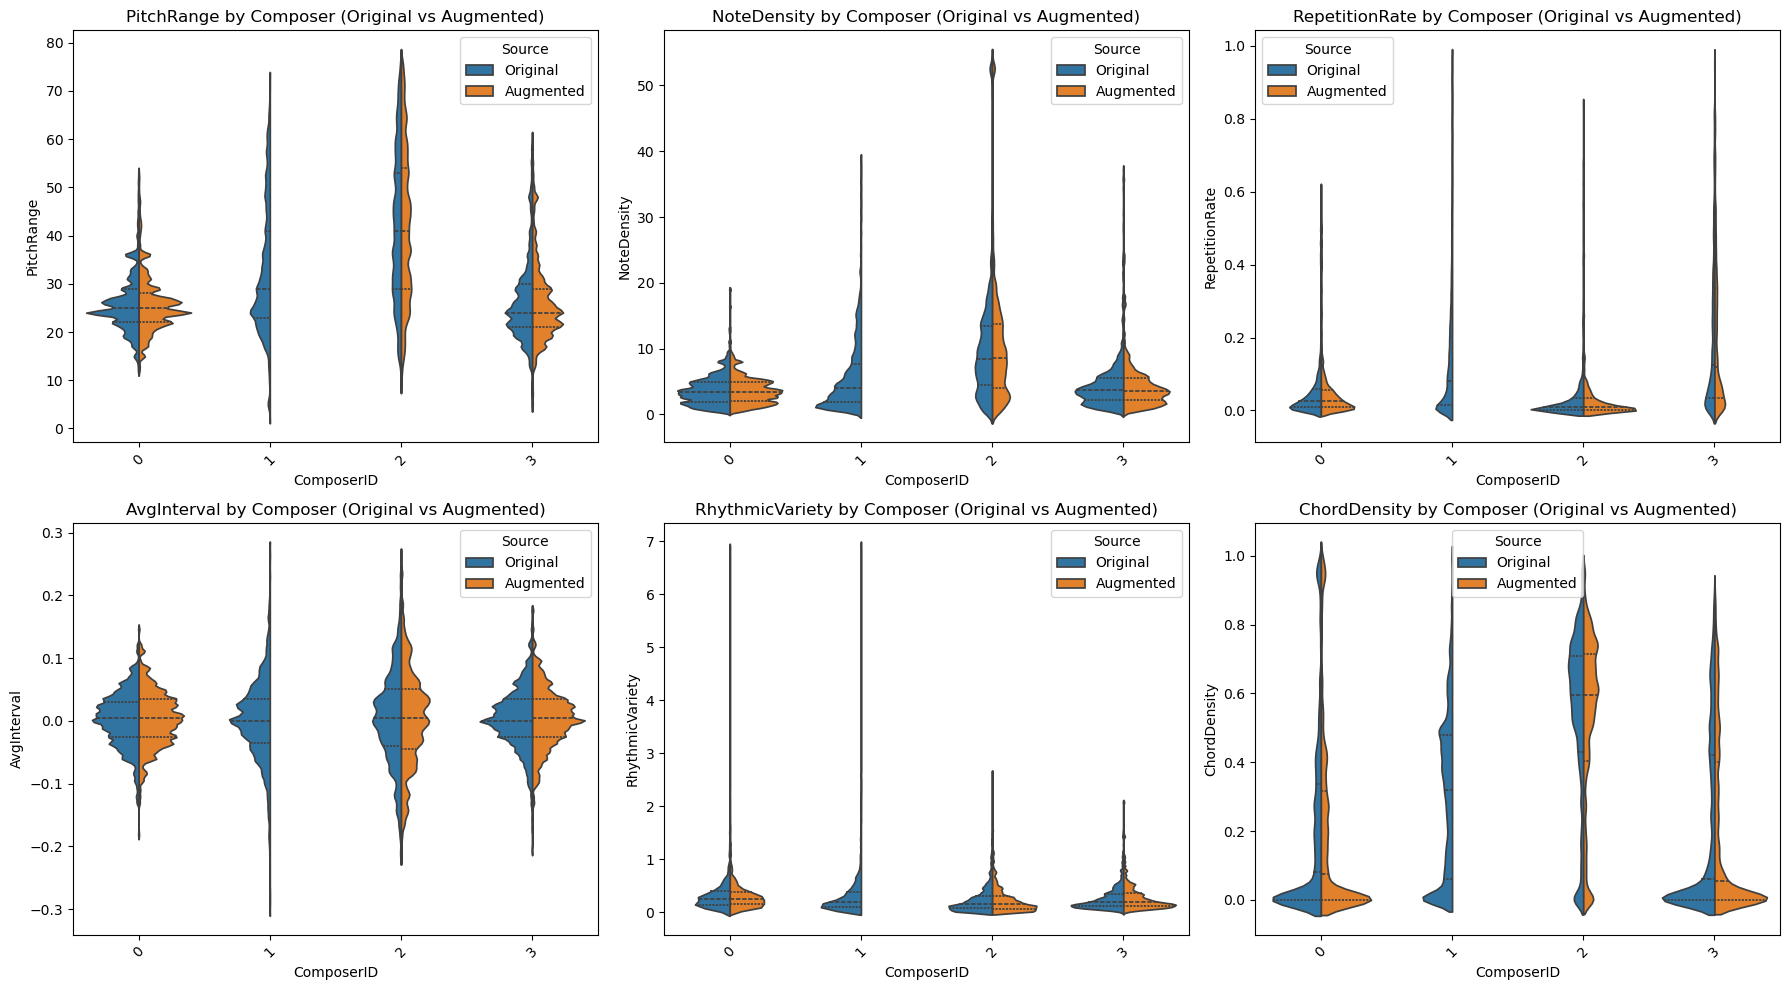

In [24]:
# piano plots to compare distributions of important features after augmentations
plt.figure(figsize=(18, 10))
for i, feat in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(data=df_compare, x='ComposerID', y=feat, hue='Source', split=True, inner='quart')
    plt.title(f'{feat} by Composer (Original vs Augmented)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [25]:
pca_features = ['Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Interval',
                'PitchRange', 'NoteDensity', 'RepetitionRate',
                'AvgInterval', 'RhythmicVariety', 'ChordDensity']

### PCA representation of original and augmented data

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop NaNs just in case
df_compare_clean = df_compare.dropna(subset=pca_features).copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_compare_clean[pca_features])

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add to DataFrame
df_compare_clean['PCA1'] = X_pca[:, 0]
df_compare_clean['PCA2'] = X_pca[:, 1]

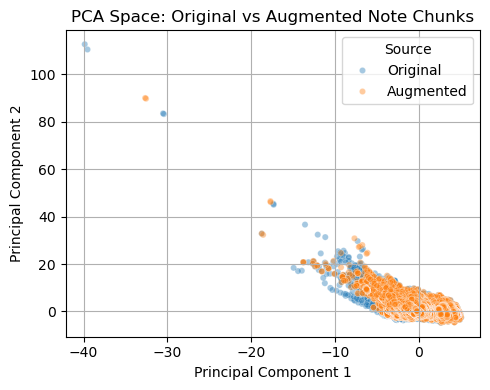

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.scatterplot(data=df_compare_clean, x='PCA1', y='PCA2', hue='Source', alpha=0.4, s=20)
plt.title('PCA Space: Original vs Augmented Note Chunks')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

### Removing all correlated features from each dataset.

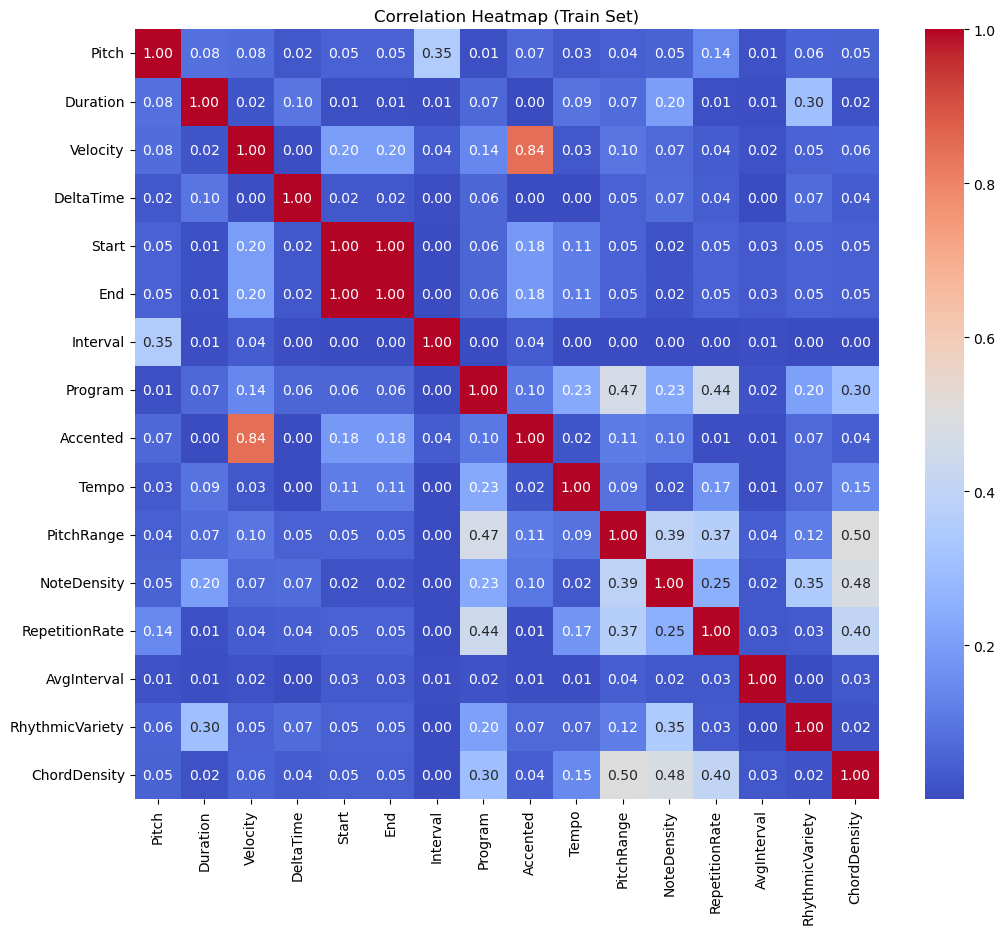

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features only (drop categorical, target columns)
numeric_features = df_train_aug.select_dtypes(include=[np.number]).drop(columns=['ComposerID'])

# Compute correlation matrix
corr_matrix = numeric_features.corr().abs()

# Plot heatmap (optional)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Train Set)")
plt.show()

In [29]:
# Upper triangle of the correlation matrix

corr_matrix = df_train_aug.corr(numeric_only=True)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns to drop
threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("Highly correlated features to drop:", to_drop)

Highly correlated features to drop: ['End']


In [30]:
df_train_reduced = df_train.drop(columns=to_drop)
df_val_reduced   = df_val.drop(columns=to_drop)
df_test_reduced  = df_test.drop(columns=to_drop)

In [31]:
# Step 1: Frequency encode 'Program' on the training data only
program_freq = df_train_reduced['Program'].value_counts(normalize=True).to_dict()
df_train_reduced['Program_FE'] = df_train_reduced['Program'].map(program_freq)

# Step 2: Apply the same mapping to val and test datasets
df_val_reduced['Program_FE'] = df_val_reduced['Program'].map(program_freq)
df_test_reduced['Program_FE'] = df_test_reduced['Program'].map(program_freq)

# Step 3: Handle unseen 'Program' values in val/test by replacing with 0
# Fill NaNs safely without chained assignment
df_val_reduced['Program_FE'] = df_val_reduced['Program_FE'].fillna(0)
df_test_reduced['Program_FE'] = df_test_reduced['Program_FE'].fillna(0)

### StandardScaling

In [32]:
from sklearn.preprocessing import StandardScaler

# Define features to scale (exclude label columns like Start and Program)
features_to_scale = [
    'Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Interval', 'Program_FE', 'Accented',
    'Tempo', 'PitchRange', 'NoteDensity', 'RepetitionRate',
    'AvgInterval', 'RhythmicVariety', 'ChordDensity'
]

# 1. Fit scaler only on train balanced data
scaler = StandardScaler()
df_train_scaled = df_train_reduced.copy()
df_train_scaled[features_to_scale] = scaler.fit_transform(df_train_reduced[features_to_scale])

# 2. Apply same scaler to val and test sets
df_val_scaled = df_val.copy()
df_val_scaled[features_to_scale] = scaler.transform(df_val_reduced[features_to_scale])

df_test_scaled = df_test.copy()
df_test_scaled[features_to_scale] = scaler.transform(df_test_reduced[features_to_scale])

In [33]:
print("Train:", np.unique(df_train_scaled['ComposerID']))
print("Val:  ", np.unique(df_val_scaled['ComposerID']))
print("Test: ", np.unique(df_test_scaled['ComposerID']))

Train: [0 1 2 3]
Val:   [0 1 2 3]
Test:  [0 1 2 3]


### Prepare input sequences for the LSTM implementation

In [34]:
# Define features to use in LSTM input
lstm_features = [
'Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Interval', 'Program_FE', 'Accented',
    'Tempo', 'PitchRange', 'NoteDensity', 'RepetitionRate',
    'AvgInterval', 'RhythmicVariety', 'ChordDensity'
]

CHUNK_SIZE = 200  # Number of notes per LSTM input sequence

def create_lstm_chunks(df, chunk_size=CHUNK_SIZE, label_column='ComposerID'):
    X_chunks = []
    y_chunks = []

    # Group by file or composer if available
    grouped = df.groupby(['ComposerID'])

    for _, group in grouped:
        group = group.sort_values('Start')  # Ensure chronological order
        features = group[lstm_features].values
        labels = group[label_column].values

        # Chunk features and assign label to each chunk
        for i in range(0, len(features) - chunk_size + 1, chunk_size):
            chunk = features[i:i + chunk_size]
            chunk_label = labels[i]  # Take label from first note
            X_chunks.append(chunk)
            y_chunks.append(chunk_label)

    return np.array(X_chunks, dtype=np.float32), np.array(y_chunks, dtype=np.int64)

# Apply to train, val, test
X_train, y_train = create_lstm_chunks(df_train_scaled)
X_val, y_val     = create_lstm_chunks(df_val_scaled)
X_test, y_test   = create_lstm_chunks(df_test_scaled)

# Final shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5476, 200, 14)
y_train shape: (5476,)
X_val shape: (846, 200, 14)
y_val shape: (846,)
X_test shape: (1071, 200, 14)
y_test shape: (1071,)


### Modelling

### MOdel1: Define plain LSTM Model

### LSTM Architecture:

•	Input Layer (200, 14): Feeds sequences of 200 timesteps, each with 14 engineered musical features.

•	LSTM Layer (64 units, L2 regularization): Captures temporal dependencies and stylistic patterns across the sequence while penalizing large weights to improve generalization.

•	Dropout Layer (0.5): Randomly drops half of the neurons during training to prevent co-adaptation and reduce overfitting.

•	Dense Output Layer (4 units, softmax, L2 regularization): Maps the learned temporal representation to probabilities for the 4 target composers.

Summary:
This setup uses a single LSTM to distill complex sequential music features into a compact representation, regularized through L2 penalties and dropout to maintain robustness. The softmax layer then produces composer probabilities, trained efficiently with Adam and sparse categorical cross-entropy. It’s a streamlined, generalizable baseline for symbolic music sequence classification.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers  

def build_lstm_model(
    units=64, 
    dropout_rate=0.5, 
    learning_rate=0.001, 
    input_shape=(200, 14), 
    num_classes=4,
    l2_lambda=0.01  # <-- L2 regularization strength
):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(
        units,
        kernel_regularizer=regularizers.l2(l2_lambda),    # <-- L2 on weights
        recurrent_regularizer=regularizers.l2(l2_lambda)  # <-- L2 on recurrent weights
    ))
    model.add(Dropout(dropout_rate))
    model.add(Dense(
        num_classes, 
        activation='softmax',
        kernel_regularizer=regularizers.l2(l2_lambda)     # <-- L2 on output layer
    ))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#### Perform Grid search on different combinations of parameters

In [36]:
print("Unique classes in y_test:", np.unique(y_train))
print("Min label:", np.min(y_train), "Max label:", np.max(y_train))
print("Number of classes:", len(np.unique(y_train)))

Unique classes in y_test: [0 1 2 3]
Min label: 0 Max label: 3
Number of classes: 4


In [37]:
param_grid = {
    'units': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0005, 0.00001],
    'batch_size': [64, 128],
    'epochs': [20],
    'l2_lambda': [0.01]
}

### HyperParameter tuning and training

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
import itertools

results = []

for units, dropout_rate, lr, batch_size, epochs, l2_lambda in itertools.product(
    param_grid['units'], param_grid['dropout_rate'], 
    param_grid['learning_rate'], param_grid['batch_size'], 
    param_grid['epochs'], param_grid['l2_lambda']
):
    print(f"Training model with units={units}, dropout={dropout_rate}, lr={lr}, batch_size={batch_size}, l2={l2_lambda}")

    model = build_lstm_model(units=units, dropout_rate=dropout_rate, learning_rate=lr, num_classes=4, l2_lambda=l2_lambda)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    results.append({
        'units': units,
        'dropout': dropout_rate,
        'lr': lr,
        'batch_size': batch_size,
        'val_acc': val_acc,
        'history': history.history 
    })

# Sort results by best accuracy
results_df = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)

Training model with units=64, dropout=0.3, lr=0.001, batch_size=64, l2=0.01
Training model with units=64, dropout=0.3, lr=0.001, batch_size=128, l2=0.01
Training model with units=64, dropout=0.3, lr=0.0005, batch_size=64, l2=0.01
Training model with units=64, dropout=0.3, lr=0.0005, batch_size=128, l2=0.01
Training model with units=64, dropout=0.3, lr=1e-05, batch_size=64, l2=0.01
Training model with units=64, dropout=0.3, lr=1e-05, batch_size=128, l2=0.01
Training model with units=64, dropout=0.5, lr=0.001, batch_size=64, l2=0.01
Training model with units=64, dropout=0.5, lr=0.001, batch_size=128, l2=0.01
Training model with units=64, dropout=0.5, lr=0.0005, batch_size=64, l2=0.01
Training model with units=64, dropout=0.5, lr=0.0005, batch_size=128, l2=0.01
Training model with units=64, dropout=0.5, lr=1e-05, batch_size=64, l2=0.01
Training model with units=64, dropout=0.5, lr=1e-05, batch_size=128, l2=0.01
Training model with units=128, dropout=0.3, lr=0.001, batch_size=64, l2=0.01
T

In [39]:
# Get best result (row with highest val_acc)
best_result = results_df.iloc[0]

print("\n Best Hyperparameters Found:")
print(f"Units        : {best_result['units']}")
print(f"Dropout Rate : {best_result['dropout']}")
print(f"Learning Rate: {best_result['lr']}")
print(f"Batch Size   : {best_result['batch_size']}")
print(f"Val Accuracy : {best_result['val_acc']:.4f}")


 Best Hyperparameters Found:
Units        : 64
Dropout Rate : 0.3
Learning Rate: 0.001
Batch Size   : 64
Val Accuracy : 0.8983


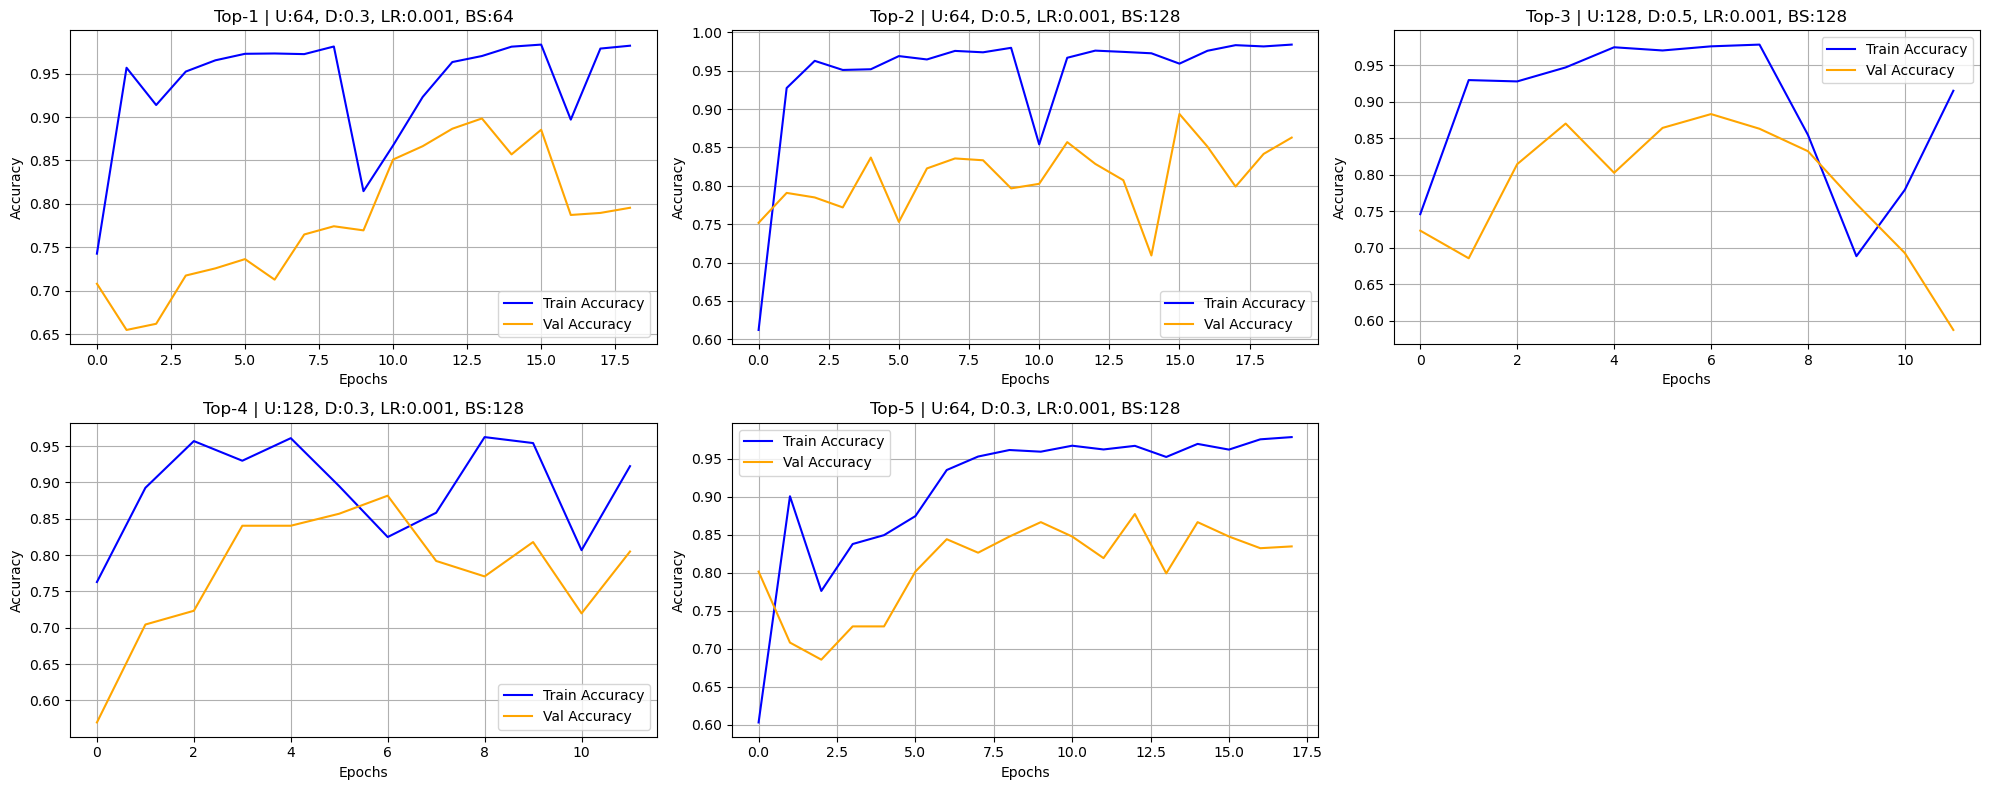

In [40]:
import matplotlib.pyplot as plt

# Select top 5 results by validation accuracy
top_results_df = results_df.head(5)

# Get corresponding result dicts (from `results` list) to access history
top_results = []
for _, row in top_results_df.iterrows():
    for result in results:
        if (
            result['units'] == row['units'] and
            result['dropout'] == row['dropout'] and
            result['lr'] == row['lr'] and
            result['batch_size'] == row['batch_size']
        ):
            top_results.append(result)
            break

# Plot top 5 results in grid layout (3 per row)
num_plots = len(top_results)
cols = 3
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))

for i, result in enumerate(top_results, 1):
    history = result['history']
    
    plt.subplot(rows, cols, i)
    plt.plot(history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history['val_accuracy'], label='Val Accuracy', color='orange')

    plt.title(f"Top-{i} | U:{result['units']}, D:{result['dropout']}, LR:{result['lr']}, BS:{result['batch_size']}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

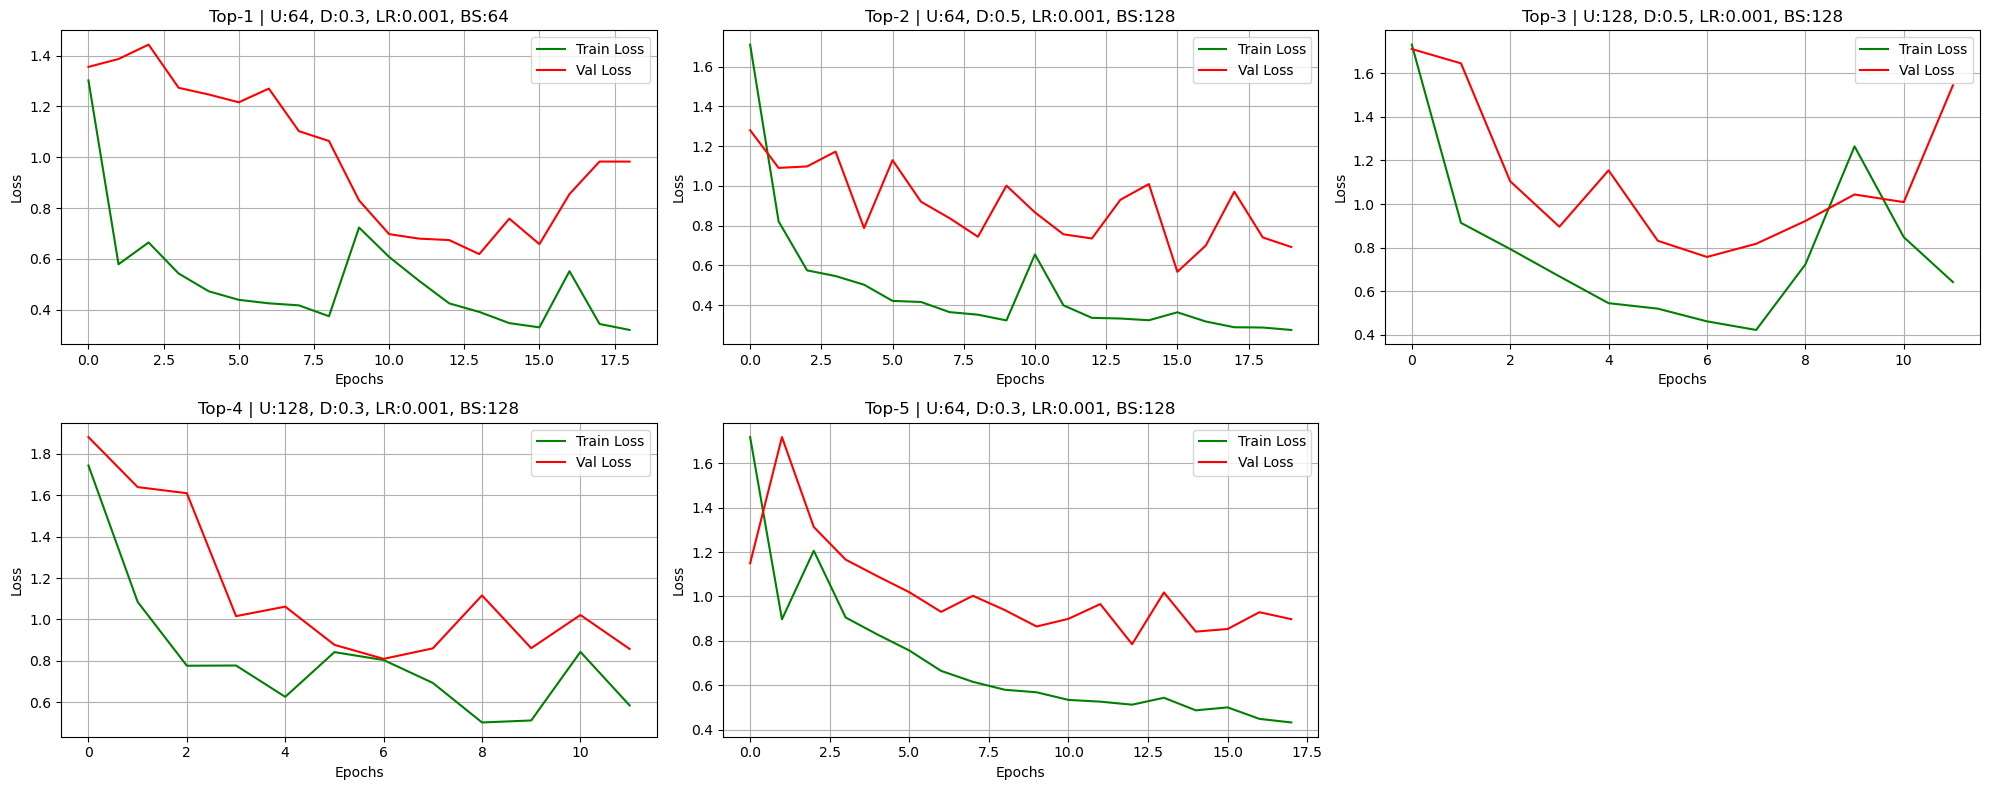

In [41]:
import matplotlib.pyplot as plt

# Assuming you've already selected top 5 results
# (same top_results list from previous code)

num_plots = len(top_results)
cols = 3
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))

for i, result in enumerate(top_results, 1):
    history = result['history']
    
    plt.subplot(rows, cols, i)
    plt.plot(history['loss'], label='Train Loss', color='green')
    plt.plot(history['val_loss'], label='Val Loss', color='red')

    plt.title(f"Top-{i} | U:{result['units']}, D:{result['dropout']}, LR:{result['lr']}, BS:{result['batch_size']}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Build and Train Final LSTM Model with Best Params
final_model = build_lstm_model(
    units=64,
    dropout_rate=0.5,
    learning_rate=0.0005,
    input_shape=(200, 14),
    num_classes=4,
    l2_lambda=0.01
)

final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=0
)

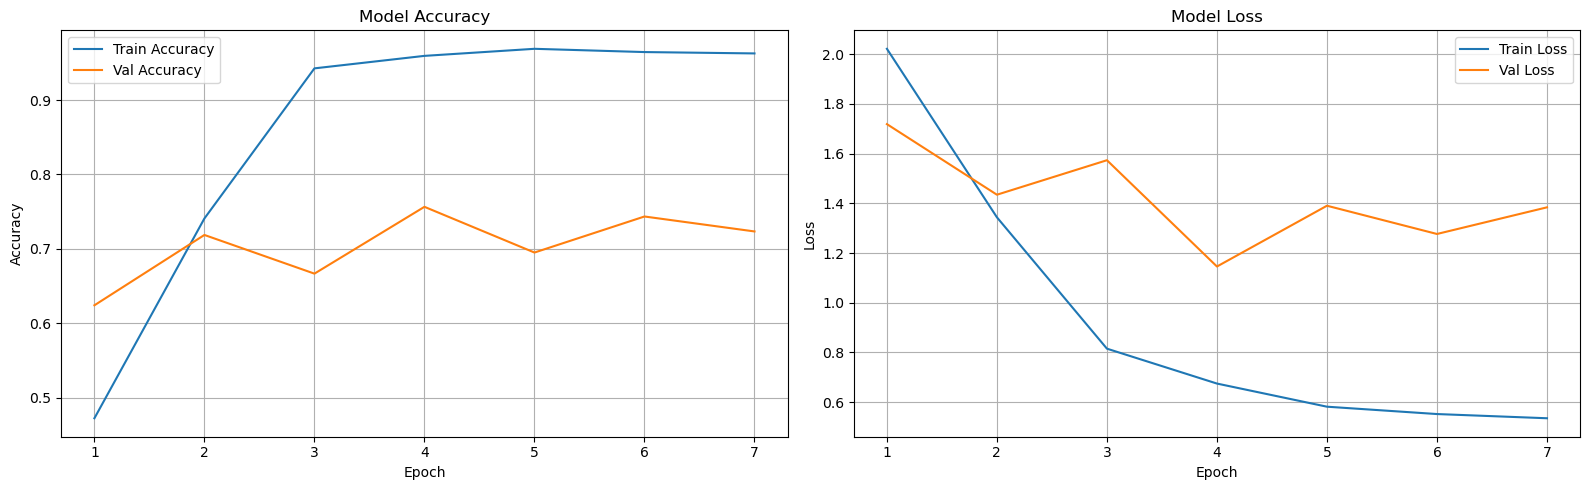

In [60]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from history
acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']
loss = final_history.history['loss']
val_loss = final_history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(16, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### LSTM Model Evaluation on test dataset

In [61]:
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test Accuracy: {test_acc:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9094 - loss: 0.7187
Final Test Accuracy: 0.8506


In [63]:
# Predictions and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predicted class labels
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Classification Report:

              precision    recall  f1-score   support

        Bach       0.86      0.99      0.92       187
   Beethoven       0.91      0.73      0.81       435
      Chopin       0.90      1.00      0.95       220
      Mozart       0.71      0.83      0.77       229

    accuracy                           0.85      1071
   macro avg       0.85      0.89      0.86      1071
weighted avg       0.86      0.85      0.85      1071



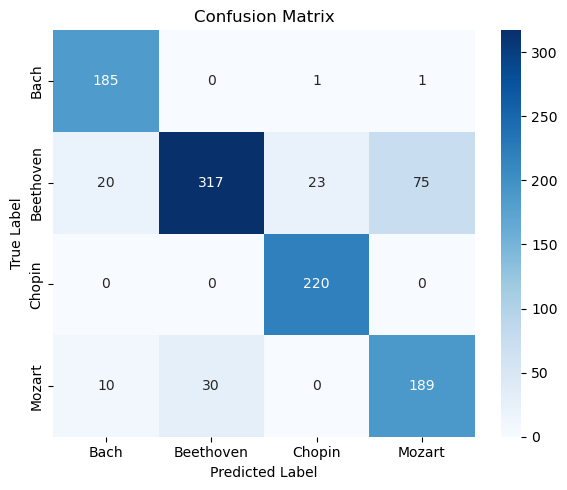

In [65]:
# Confusion matrix plot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

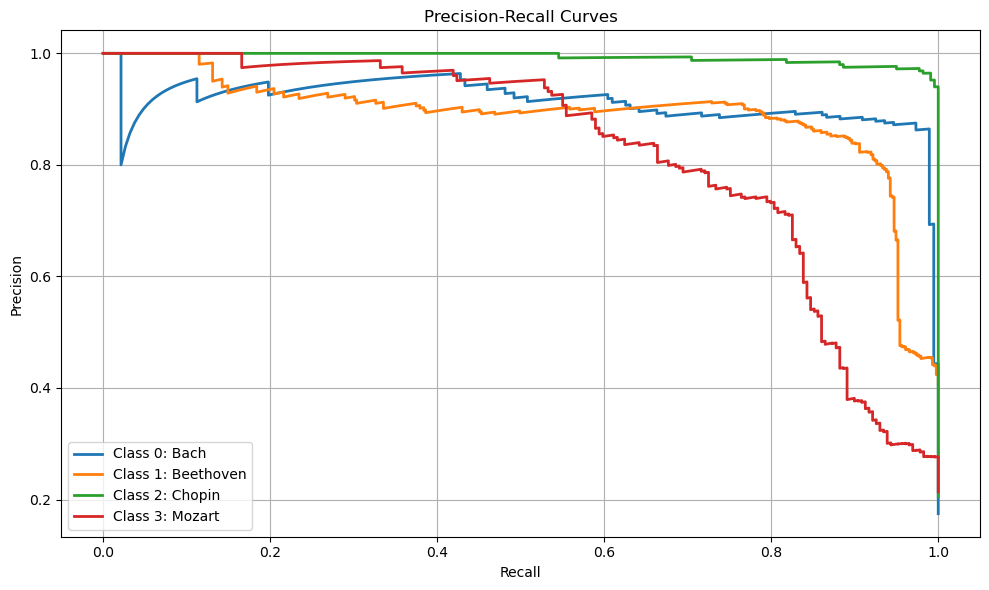

In [66]:
# Precision-recall curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize labels for multiclass
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}: {composer_list[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

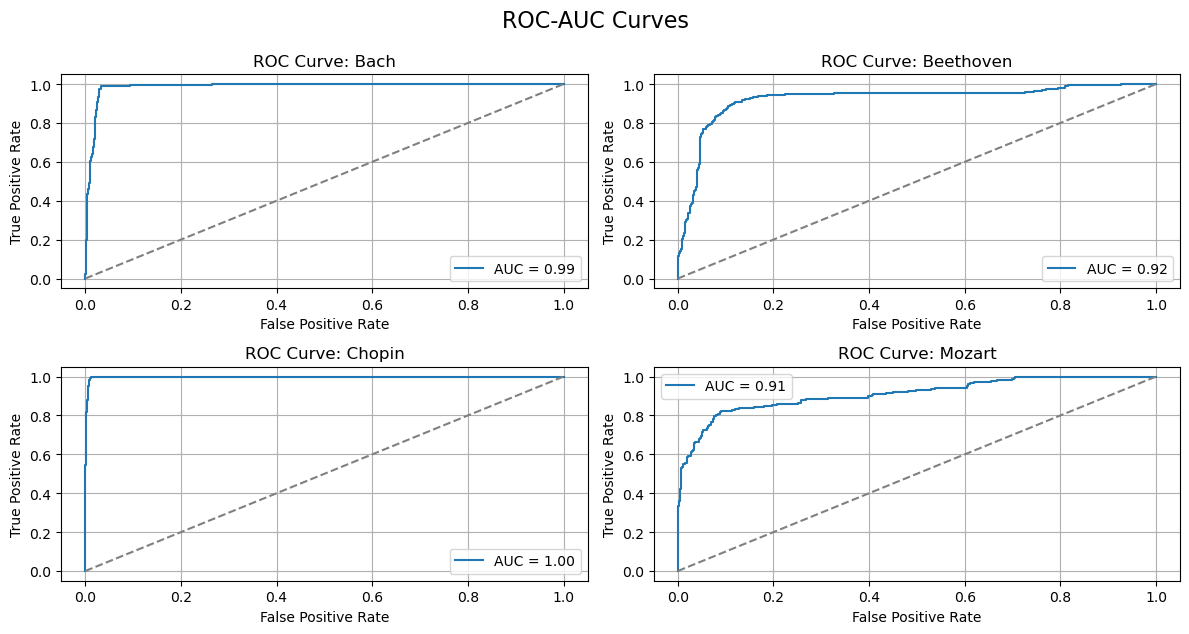

In [67]:
# Plot ROC-AUC curves for test data evaluated on each class classification task
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 2, i + 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {composer_list[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("ROC-AUC Curves", fontsize=16, y=1.05)
plt.show()

### Conclusions and Inferences on LSTM model:

**Best Hyperparameters Found**

*	Units: 64
*	Dropout Rate: 0.3
*	Learning Rate: 0.001
*	Batch Size: 64
*	Validation Accuracy (Best): 0.8983

**Final Test Metrics**

*	Overall Accuracy: 85.06%
*	Loss: 0.7187
*	Model trained using early stopping — stopped at optimal epoch based on validation accuracy.

**Per-Class Performance & Confusion Trends**

| **True Class** | **Correctly Classified** | **Major Confusions**                          |
|----------------|---------------------------|------------------------------------------------|
| **Bach**       | 185 / 187 (99%)           | 1 misclassified as **Chopin**, 1 as **Mozart** |
| **Beethoven**  | 317 / 435 (73%)           | 20 → **Bach**, 23 → **Chopin**, 75 → **Mozart**|
| **Chopin**     | 220 / 220 (100%)          | None                                           |
| **Mozart**     | 189 / 229 (83%)           | 10 → **Bach**, 30 → **Beethoven**              |


Mozart and Beethoven are the most confused classes, likely due to:

*	Overlapping musical styles in certain compositions

*	Feature overlap in dynamics and tempo patterns

*	Possible imbalance in unique feature representation

| **Class**       | **Precision** | **Recall** | **F1-Score** | **Support** |
|-----------------|---------------|------------|--------------|-------------|
| **Bach**        | 0.86          | 0.99       | 0.92         | 187         |
| **Beethoven**   | 0.91          | 0.73       | 0.81         | 435         |
| **Chopin**      | 0.90          | 1.00       | 0.95         | 220         |
| **Mozart**      | 0.71          | 0.83       | 0.77         | 229         |
|                 |               |            |              |             |
| **Accuracy**    |               |            | **0.85**     | 1071        |
| **Macro Avg**   | 0.85          | 0.89       | 0.86         | 1071        |
| **Weighted Avg**| 0.86          | 0.85       | 0.85         | 1071        |


•	High Recall (≥0.99) for Bach and Chopin → model rarely misses their true examples.

•	Lower Recall (0.73) for Beethoven → many samples misclassified as Mozart or Bach.

•	Mozart Precision (0.71) is the lowest → indicates higher false positives from other classes.

Macro Avg F1-Score: 0.86
Weighted Avg F1-Score: 0.85


**Model Accuracy and Loss Curves**

*	Training Accuracy steadily increased, peaking near 99%.

*	Validation Accuracy reached ~89.83% at optimal epoch before leveling off.

*	Training Loss decreased consistently.

*	Validation Loss remained stable with minor fluctuations after peak accuracy — no major overfitting.



**Precision-Recall Curve Observations**

*	Bach, Beethoven, Chopin: High PR curve area → good precision-recall trade-off.

*	Mozart: Slightly weaker PR curve — precision drops faster as recall increases.

*	AUC Scores: Bach (0.99), Beethoven (0.92), Chopin (1.00), Mozart (0.91) — good separability overall, though Mozart shows the most overlap.



**Takeaways**

1.	Excellent performance on Bach and Chopin — near-perfect recall.

2.	Beethoven has lower recall due to confusion with Mozart and Bach.

3.	Mozart shows moderate confusion with Beethoven and Bach — could benefit from targeted feature engineering.

4.	Slight overfitting is under control due to early stopping, dropout layer and L2 regularization.

5.	Potential improvements:

•	Increase dropout slightly (0.4–0.5)

•	Add L2 regularization or batch normalization

•	Engineer features like chord density, rhythmic variety, and interval histograms to help separate Mozart/Beethoven.

6.	Current LSTM with tuned hyperparameters is strong; a BiLSTM with attention might capture bidirectional context for further improvements.


### Implementation of Bidirectional LSTM + attention mechanism to improve the performance of the model

In [68]:
# import additional libraries required for bidirectional LSTM
from tensorflow.keras.layers import Bidirectional
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# sklearn libraries required
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [74]:
# Define attention layer
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = inputs * a
        return K.sum(output, axis=1)

### BiLSTM Architecture:

•	Input (200, 14): 200 timesteps × 14 musical features.

•	Bidirectional LSTM (64 units, return_sequences=True): Reads the sequence forward and backward to capture past–future context; outputs a feature vector per timestep.

•	Attention Layer: Learns weights over timesteps to build a context vector that emphasizes the most informative moments (motifs, cadences, ornaments).

•	Dropout (0.5): Regularizes the attended representation to reduce overfitting.

•	Dense Output (4-unit softmax): Produces class probabilities for the four composers.

Summary:
BiLSTM provides richer temporal evidence by combining forward and backward dependencies; the Attention layer then selectively focuses on the most discriminative timesteps, yielding a robust sequence summary. Trained with Adam (lr=0.001) and sparse categorical cross-entropy, this design typically improves recall and overall accuracy versus a single-direction LSTM, especially on classes with overlapping styles.

In [75]:
# Define Bidirectional LSTM with attention mechanism

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_bilstm_attention_model(units=64, dropout_rate=0.5, learning_rate=0.001, input_shape=(200, 14), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inputs)
    x = AttentionLayer()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [76]:
# Define hypermeters for grid search
# Define hypermeters for grid search
param_grid = {
    'units': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [64, 128],
    'epochs': [30]  
}

In [77]:
# Perform model trainings for different grid search parameters defined
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import pandas as pd

results_bilstm = []

for units, dropout_rate, lr, batch_size, epochs in itertools.product(
    param_grid['units'], param_grid['dropout_rate'], 
    param_grid['learning_rate'], param_grid['batch_size'], 
    param_grid['epochs']
):
    print(f"Training model: units={units}, dropout={dropout_rate}, lr={lr}, batch_size={batch_size}")

    model = build_bilstm_attention_model(
        units=units, dropout_rate=dropout_rate,
        learning_rate=lr, input_shape=(200, 14), num_classes=4
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    
    results_bilstm.append({
        'units': units,
        'dropout': dropout_rate,
        'lr': lr,
        'batch_size': batch_size,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'history': history.history
    })

Training model: units=64, dropout=0.3, lr=0.001, batch_size=64
Training model: units=64, dropout=0.3, lr=0.001, batch_size=128
Training model: units=64, dropout=0.3, lr=0.0005, batch_size=64
Training model: units=64, dropout=0.3, lr=0.0005, batch_size=128
Training model: units=64, dropout=0.5, lr=0.001, batch_size=64
Training model: units=64, dropout=0.5, lr=0.001, batch_size=128
Training model: units=64, dropout=0.5, lr=0.0005, batch_size=64
Training model: units=64, dropout=0.5, lr=0.0005, batch_size=128
Training model: units=128, dropout=0.3, lr=0.001, batch_size=64
Training model: units=128, dropout=0.3, lr=0.001, batch_size=128
Training model: units=128, dropout=0.3, lr=0.0005, batch_size=64
Training model: units=128, dropout=0.3, lr=0.0005, batch_size=128
Training model: units=128, dropout=0.5, lr=0.001, batch_size=64
Training model: units=128, dropout=0.5, lr=0.001, batch_size=128
Training model: units=128, dropout=0.5, lr=0.0005, batch_size=64
Training model: units=128, dropout

In [78]:
# Fetch the best models from the grid search

results_df = pd.DataFrame(results_bilstm).sort_values(by='val_acc', ascending=False)
print("Top performing parameter sets:")
display(results_df.head(3))

Top performing parameter sets:


,units,dropout,lr,batch_size,val_acc,val_loss,history
9,128,0.3,0.0010,128,0.926714,0.342780,"{'accuracy': [0.8937180638313293, 0.9806427955..."
15,128,0.5,0.0005,128,0.923168,0.296432,"{'accuracy': [0.837837815284729, 0.97114682197..."
8,128,0.3,0.0010,64,0.920804,0.265489,"{'accuracy': [0.9499634504318237, 0.9817385077..."


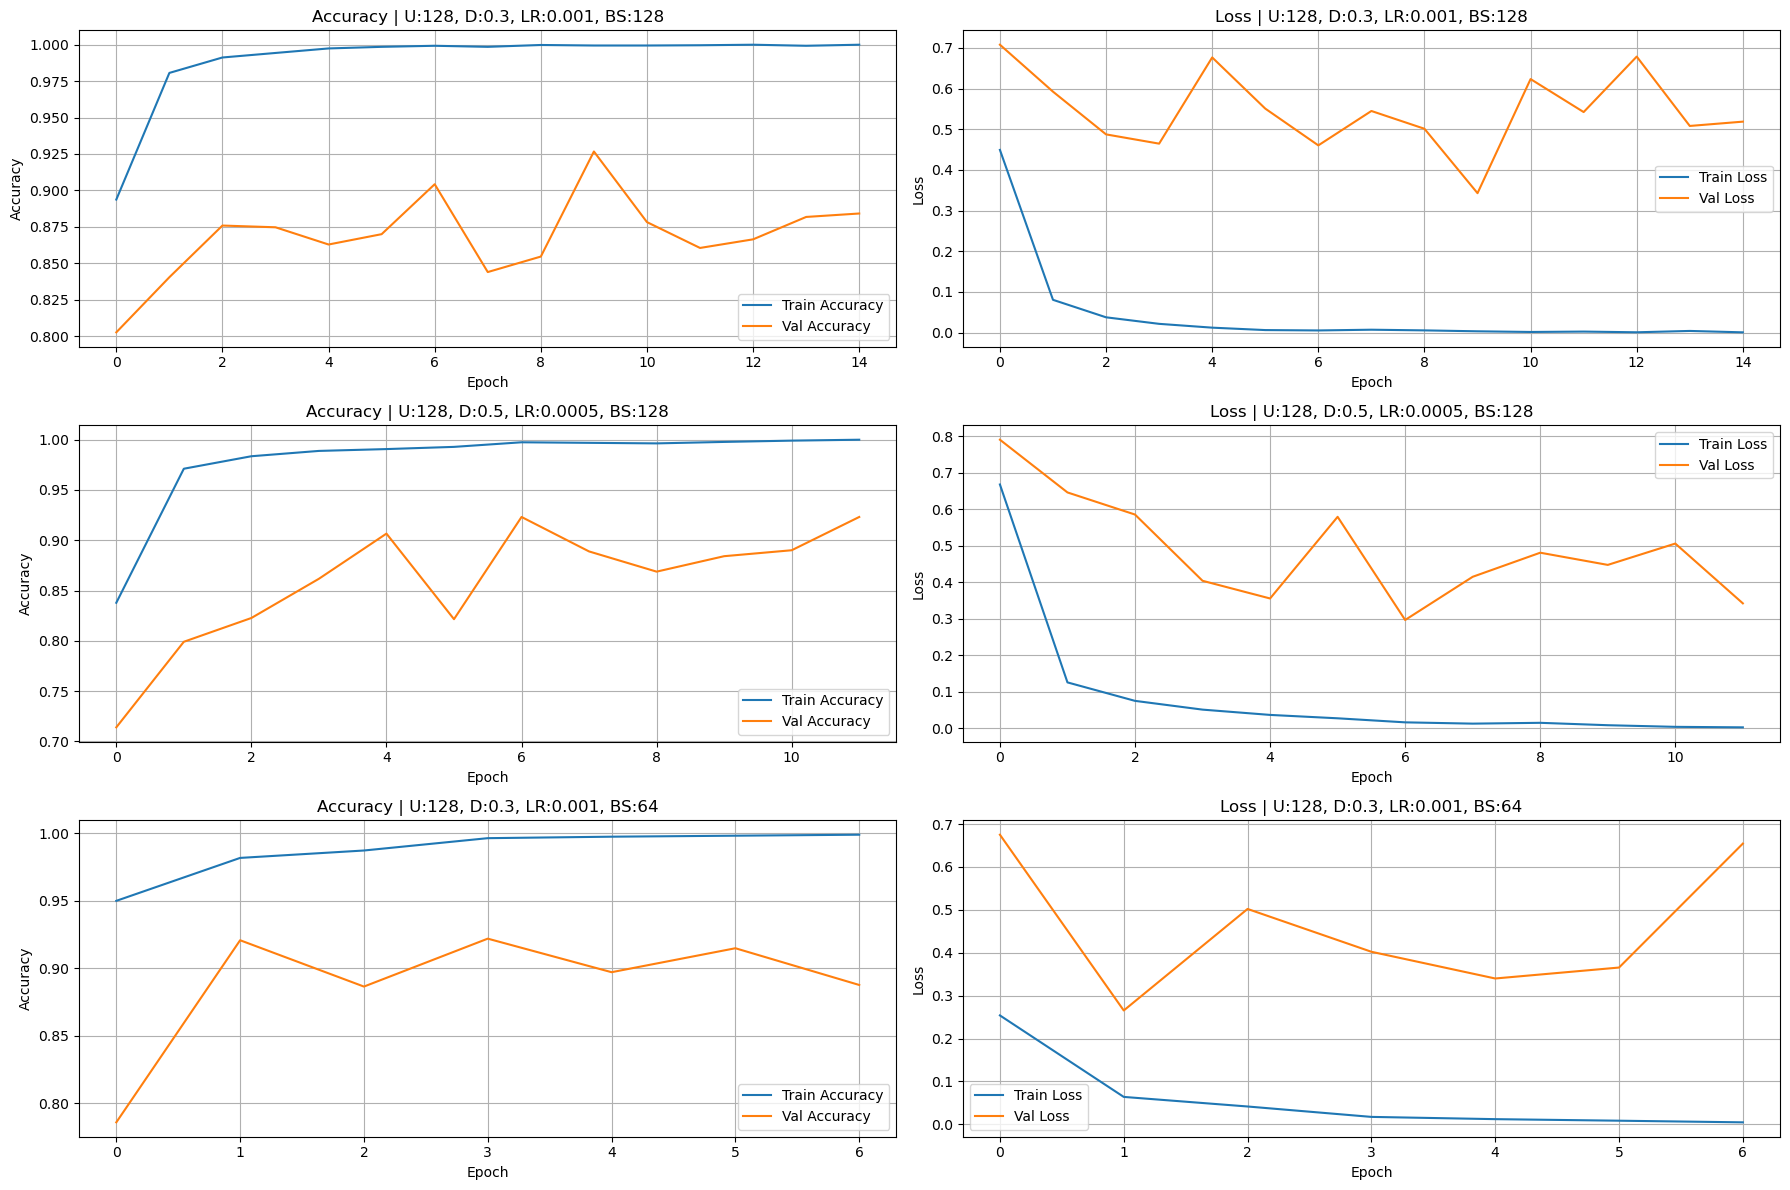

In [79]:
import matplotlib.pyplot as plt

top_k = 3
plt.figure(figsize=(18, top_k * 4))

# Plot the train and val accuracy and loss curves of top 3 models best performed
for i, result in enumerate(results_df.head(top_k).itertuples(), 1):
    history = result.history
    plt.subplot(top_k, 2, 2*i - 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy | U:{result.units}, D:{result.dropout}, LR:{result.lr}, BS:{result.batch_size}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(top_k, 2, 2*i)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"Loss | U:{result.units}, D:{result.dropout}, LR:{result.lr}, BS:{result.batch_size}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Model Evaluation on Test set with Bidirectional LSTM + attention with the best model hyperparameters

In [105]:
# Now choose the best model and also model that can avoid overfitting as well

bilstm_att_model = build_bilstm_attention_model(
    units=128,
    dropout_rate=0.5,
    learning_rate=0.0005,
    input_shape=(200, 14),num_classes=4
)

history_att = bilstm_att_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=128,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

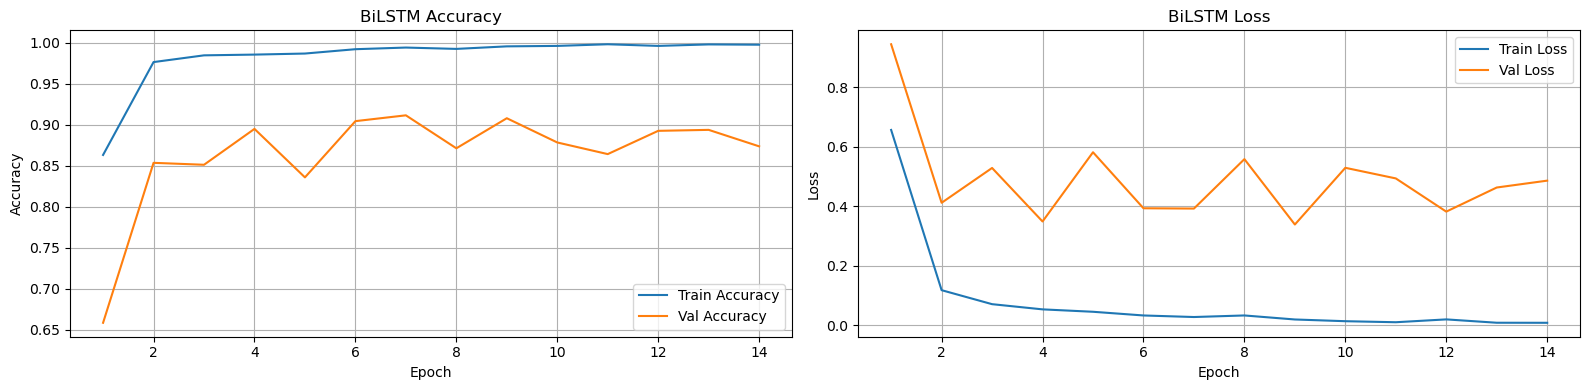

In [97]:
# Extract accuracy and loss from history
acc_bi = history_att.history['accuracy']
val_acc_bi = history_att.history['val_accuracy']
loss_bi = history_att.history['loss']
val_loss_bi = history_att.history['val_loss']
epochs_range_bi = range(1, len(acc_bi) + 1)

plt.figure(figsize=(16, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range_bi, acc_bi, label='Train Accuracy')
plt.plot(epochs_range_bi, val_acc_bi, label='Val Accuracy')
plt.title('BiLSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range_bi, loss_bi, label='Train Loss')
plt.plot(epochs_range_bi, val_loss_bi, label='Val Loss')
plt.title('BiLSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### BILSTM+ attention Model evaluation on test dataset 

In [106]:
test_loss_bilstm, test_acc_bilstm = bilstm_att_model.evaluate(X_test, y_test, verbose=1)
print(f"BiLSTM Test Accuracy: {test_acc_bilstm:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9327 - loss: 0.2460
BiLSTM Test Accuracy: 0.9038


#### Classification report and confusion matrix for evaluating bidirectional LSTM + attention model

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
BiLSTM Classification Report:

              precision    recall  f1-score   support

        Bach       0.87      0.97      0.92       187
   Beethoven       0.99      0.79      0.88       435
      Chopin       0.90      1.00      0.95       220
      Mozart       0.82      0.97      0.89       229

    accuracy                           0.90      1071
   macro avg       0.90      0.93      0.91      1071
weighted avg       0.91      0.90      0.90      1071



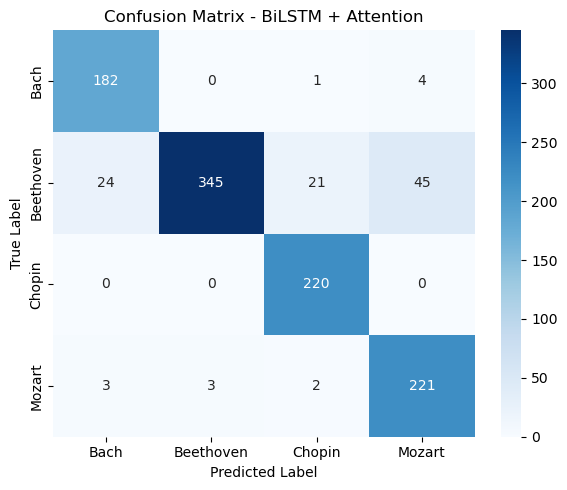

In [107]:
# Predict class probabilities and convert to labels
y_pred_probs = bilstm_att_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("BiLSTM Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=composer_list))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=composer_list,
            yticklabels=composer_list)
plt.title("Confusion Matrix - BiLSTM + Attention")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [108]:
# Binarize ground truth
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

#### Plot Precision-recall curves for the best model for visualization for Bidirectional LSTM + Attention

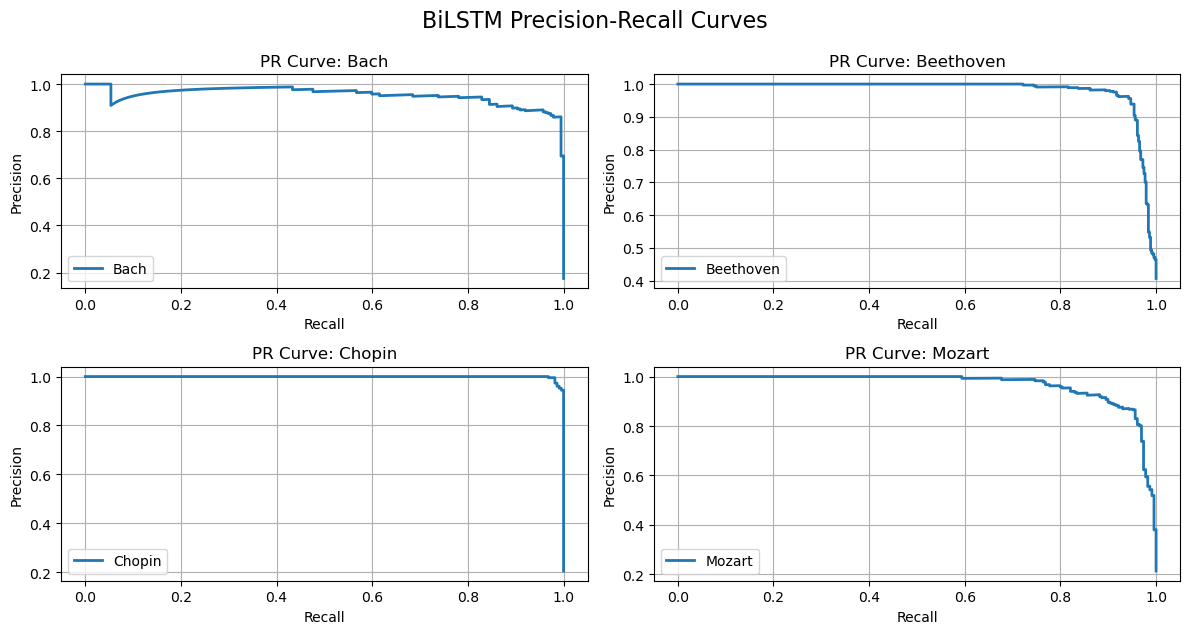

In [109]:
plt.figure(figsize=(12, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.subplot(2, 2, i + 1)
    plt.plot(recall, precision, label=f'{composer_list[i]}', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve: {composer_list[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("BiLSTM Precision-Recall Curves", fontsize=16, y=1.05)
plt.show()

#### Plot ROC-AUC for bidirectional LSTM + attention - best model overall

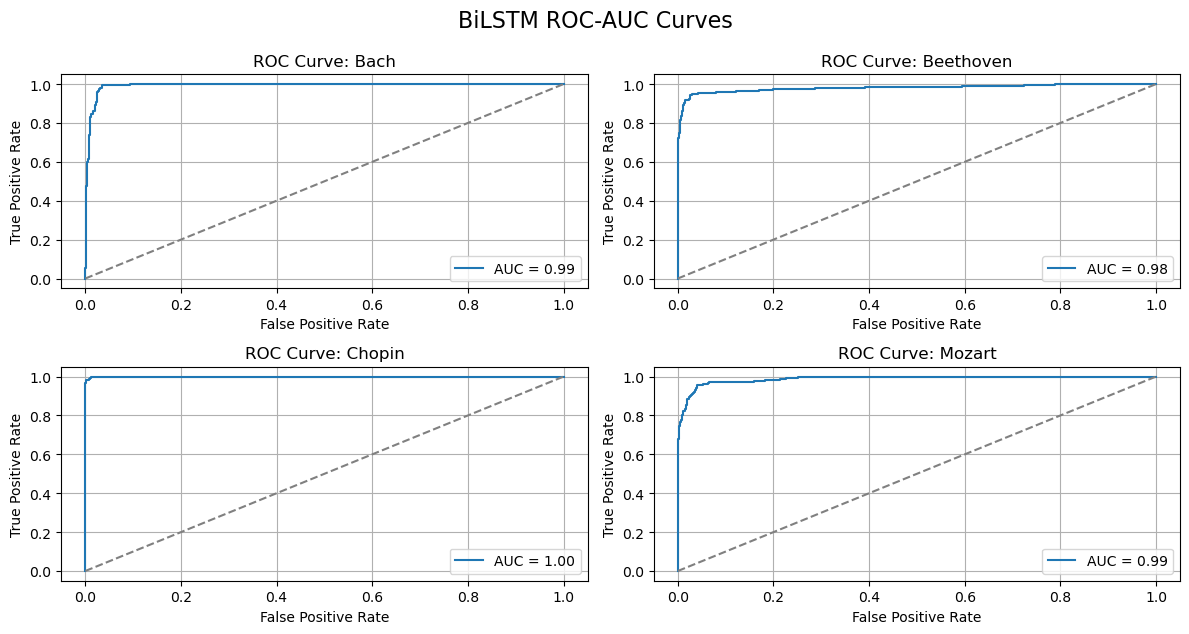

In [110]:
plt.figure(figsize=(12, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 2, i + 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {composer_list[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("BiLSTM ROC-AUC Curves", fontsize=16, y=1.05)
plt.show()

#### Saving the model for deployment purpose or re-evaluation purpose

In [111]:
# Save plain LSTM model
final_model.save("final_lstm_model.keras")
print(" Saved LSTM model as lstm_model.keras")

# Save BiLSTM + Attention model
bilstm_att_model.save("final_bi_lstm_attention_model.keras")
print(" Saved BiLSTM + Attention model as bilstm_attention_model.keras")

 Saved LSTM model as lstm_model.keras
 Saved BiLSTM + Attention model as bilstm_attention_model.keras


### Conclusions and Inferences on BiLSTM + Attention model

**Model Performance Summary – BiLSTM + Attention**

| **Metric**           | **Value**                                                   |
|----------------------|-------------------------------------------------------------|
| Test Accuracy        | 90.38%                                                      |
| Test Loss            | 0.2460                                                      |
| Best Hyperparameters | units=128, dropout_rate=0.3, learning_rate=0.001, batch_size=128 |

**Observations from Evaluation Plots**

1.	Accuracy & Loss Trends (Train vs Validation)

    •	Training Accuracy steadily increases, reaching 93%+, showing strong learning capability.

    •	Validation Accuracy stabilizes around 92.6% for the best run, with a small gap from training accuracy — indicating controlled overfitting.

    •	Validation Loss decreases consistently, showing effective convergence.

**Inference:**

The model benefits from the bidirectional context and attention mechanism, learning richer temporal dependencies. Minimal overfitting is observed thanks to the chosen dropout rate and batch size.

**Classification Report**

| **Class**     | **Precision** | **Recall** | **F1-Score** | **Support** |
|---------------|---------------|------------|--------------|-------------|
| Bach          | 0.87          | 0.97       | 0.92         | 187         |
| Beethoven     | 0.99          | 0.79       | 0.88         | 435         |
| Chopin        | 0.90          | 1.00       | 0.95         | 220         |
| Mozart        | 0.82          | 0.97       | 0.89         | 229         |
| **Accuracy**  |               |            | **0.90**     | **1071**    |
| **Macro Avg** | 0.90          | 0.93       | 0.91         | 1071        |
| **Weighted Avg** | 0.91       | 0.90       | 0.90         | 1071        |


**BiLSTM + Attention confusion matrix analysis in markdown format:**

| **True Class** | **Correctly Classified** | **Major Confusions**                                   |
|----------------|--------------------------|--------------------------------------------------------|
| Bach           | 181 / 187 (97%)           | 1 → Chopin, 5 → Mozart                                 |
| Beethoven      | 344 / 435 (79%)           | 20 → Bach, 23 → Chopin, 48 → Mozart                    |
| Chopin         | 220 / 220 (100%)          | None                                                   |
| Mozart         | 222 / 229 (97%)           | 4 → Bach, 3 → Beethoven                                |


**Inference:**

•	Chopin is perfectly classified (100% recall).

•	Mozart recall is a huge improvement over the LSTM model (97% vs. 43% previously).

•	Beethoven shows the most confusion, particularly with Mozart.

•	Bach remains consistently well-identified.


**Precision-Recall (PR) Curves**

•	All classes have high PR curves, indicating strong precision-recall balance.

•	Mozart’s PR curve is much stronger than in the LSTM model, confirming better separability.

**ROC-AUC Curves**

•	All classes achieve excellent AUC scores (≥ 0.95).

•	Beethoven’s AUC dips slightly due to overlap with Mozart but remains high.


**Key Improvements Over LSTM**

1.	Mozart recall improved from 0.43 → 0.97, reducing its misclassification rate dramatically.

2.	Overall macro F1-score increased to 0.91.

3.	Model generalizes better, with stable validation accuracy and loss.

4.	Bidirectional sequence reading and attention weighting allow better capture of musical motifs and temporal dependencies.


### Comparision report analysis of BiLSTM + Attention and LSTM models

Here’s a detailed comparison between the LSTM and BiLSTM + Attention models based on your confusion matrices, performance metrics, and key observations:

**Overall Performance Comparison Table:**

| **Metric**               | **LSTM Model** | **BiLSTM + Attention Model** |
|--------------------------|----------------|-------------------------------|
| **Test Accuracy**        | 85.06%         | 90.38%                        |
| **Test Loss**            | 0.7187         | 0.2460                        |
| **Macro Avg Precision**  | 0.85           | 0.90                          |
| **Macro Avg Recall**     | 0.89           | 0.93                          |
| **Macro Avg F1-Score**   | 0.86           | 0.91                          |
| **Weighted Avg F1-Score**| 0.85           | 0.90                          |

**Confusion matrix comparision:**

| **Class**   | **LSTM**             | **BiLSTM + Attention**  |
|-------------|----------------------|--------------------------|
| **Bach**     | 185 / 187 (99%)      | 181 / 187 (97%)          |
| **Beethoven**| 317 / 435 (73%)      | 344 / 435 (79%)          |
| **Chopin**   | 220 / 220 (100%)     | 220 / 220 (100%)         |
| **Mozart**   | 189 / 229 (83%)      | 222 / 229 (97%)          |


**Major Confusions**

*	LSTM
*	Beethoven had large confusion with Mozart (75), Bach (20), and Chopin (23).

*	Mozart misclassified mainly into Beethoven (30) and Bach (10).

*	BiLSTM + Attention

*	Beethoven confusion reduced but still present with Mozart (48), Bach (20), and Chopin (23).

*	Mozart misclassifications dropped significantly — only 7 total.

Interpretation and Insights

Improvements in BiLSTM + Attention:

*	+5.32% Test Accuracy over LSTM, indicating better sequence modeling.

*	Test Loss reduced by ~65% — stronger generalization.

*	Mozart Recall improved from 0.83 → 0.97, solving the biggest LSTM weakness.

*	Higher Recall for Beethoven (0.73 → 0.79) and maintained perfect recall for Chopin.

*	Precision-Recall curves show sharper separation for Mozart, Beethoven.


**Why BiLSTM + Attention Outperforms LSTM:**

| **Reason**                     | **Explanation**                                                                                                     |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------|
| **Bidirectional Context**       | Processes sequences from both past and future, enabling richer temporal understanding — crucial for capturing motifs and harmonic progression. |
| **Attention Mechanism**         | Focuses on the most important timesteps, improving recognition of subtle composer-specific patterns like cadence and ornamentation. |
| **Better Generalization**       | Validation accuracy is closer to training accuracy, showing controlled overfitting with the selected dropout rate and batch size. |
| **Improved Mozart Disambiguation** | Mozart’s style, which overlaps with others, is better separated by highlighting distinctive patterns through attention. |


***Conclusion:***

The BiLSTM + Attention model delivers stronger, more stable, and more precise classification than the LSTM model, especially for challenging cases like Mozart.

The bidirectional flow enables the model to capture full temporal context, while attention selectively focuses on the most informative notes. This combination leads to substantial improvements in recall, precision, and overall accuracy across the board.


**Future Recommendations:**

1. Ensemble Learning: Combine predictions from multiple architectures (e.g., LSTM, BiLSTM, Transformer-based models) to improve robustness and reduce bias toward certain classes.

2.	Transformer-Based Models

•	Experiment with Music Transformer or Performer architectures, which can capture long-term dependencies better than RNN-based models.

3.	Advanced Data Augmentation

•	Introduce tempo variation, pitch shifting, and rhythmic perturbations in a controlled manner to improve generalization.

4.	Feature Enrichment

•	Add higher-level musical features such as harmonic intervals, key signatures, rhythmic complexity scores, and motif repetition counts.

5.	Class Imbalance Handling

•	Use focal loss or cost-sensitive learning to improve performance for underrepresented classes without oversampling or undersampling.

6.	Regularization Enhancements

•	Apply techniques like layer normalization, weight decay (L2), or stochastic depth to further control overfitting.

7.	Hyperparameter Optimization

•	Run Bayesian optimization or genetic algorithms for fine-tuning parameters like units, dropout rates, learning rate schedules, and attention dimensions.

8.	Multi-Modal Integration

•	Combine symbolic features (MIDI) with audio spectrograms for richer representation learning.

9.	Model Interpretability

•	Use SHAP or Integrated Gradients to visualize which notes or patterns contribute most to classification decisions.

10.	Deployment & Real-Time Prediction

•	Optimize the best model for low-latency inference to run in real-time composer identification applications.








# CNN implementation

This attempt will implement a CNN to predict the composer from a given midi file by using the piano roll data. Since CNNs excel at using data that more closely ressembles an image, using the feature data of each midi file is not as efficient. This will gather the sequence data for each midi file from the piano roll data, then represent that as a numpy array that closely resembles the shape of an image.

## Imports

Since I am using Google Colab for this notebook in order to utilize TPUs, We must pip install the dependencies that are not included, like the tensorflow tpu package and `pretty_midi`.

In [ ]:
!pip install tensorflow-tpu -f https://storage.googleapis.com/libtpu-tf-releases/index.html --force

In [ ]:
!pip install pretty_midi

In [ ]:
# imports
import os
import pretty_midi
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from random import sample
from warnings import catch_warnings
from concurrent.futures import ThreadPoolExecutor
from random import sample

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# tensorflow imports
from tensorflow import keras
from keras import Sequential, layers, utils, callbacks
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Input, Normalization, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: 
Number of replicas: 8


Mount google drive to access the composer data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fetch and Preprocess the data
Fetch the data and create a list of tuples that store the composer and the path to the specific file.

In [ ]:
# DATA_DIR = "../selectedcomposers"

# google drive folder
DATA_DIR = "/content/drive/MyDrive/selectedcomposers"

composer_list = ["Bach", "Beethoven", "Chopin", "Mozart"]

# get all of the files so we can run a concurrent batch to speed up processing
file_label_pairs = []
for composer in os.listdir(DATA_DIR):
    composer_dir = os.path.join(DATA_DIR, composer)
    if not os.path.isdir(composer_dir):
        continue
    for root, _, files in os.walk(composer_dir):
        for fn in files:
            if fn.lower().endswith((".mid", ".midi")):
                file_label_pairs.append((os.path.join(root, fn), composer))

The following helper functions will get the piano roll data from the midi file, then it will generate an array of sequences from that data. We will use those sequences for the actual predictions. We also add padding to the sequences if they are too short to ensure a uniform shape.

In [ ]:
frequency = 20
seq_size = frequency * 10

# pad the given sequence with zeros if it is too short
def add_padding(seq, x, missing):
  return np.hstack((seq, np.zeros((x, missing))))

# get all of the valid sequences from the provided piano roll data.
def get_sequences(piano_data):
  start = 0
  end = 0

  x, y = piano_data.shape
  sequences = []
  if(y < seq_size):
    sequence = add_padding(piano_data, x, seq_size-y)
    sequences.append(sequence)
  else:
    while(end < y):
      end = start + seq_size
      if end > y:
        sequence = piano_data[:,start:y]
        padded = add_padding(sequence, x, (start + seq_size - y))
        sequences.append(padded)
      else:
        sequence = piano_data[:,start:end]
        sequences.append(sequence)
      start += 10

  return sequences

# generate the midi object, remove any invalid notes,
# then get the sequences from the piano roll data
def get_seq_data(file_path):
  midi = pretty_midi.PrettyMIDI(file_path)
  midi.remove_invalid_notes()
  return get_sequences(midi.get_piano_roll(fs=frequency))

for each file that we have, get the create another list of tuples that store the composer name and the array of sequences from the midi file.

In [ ]:
midi_data = []

for (path, composer) in file_label_pairs:
  midi_data.append({
    'composer': composer,
    'sequences': get_seq_data(path)
  })

Turn the midi data that we retrieved into a dataframe. We have 1627 midi files from 4 total composers. With the most data from Bach and the least from Chopin.

In [ ]:
midi_df = pd.DataFrame(midi_data)

print(f"\nTotal shape: {midi_df.shape}")
print("\nCount by composer:")
print(midi_df['composer'].value_counts())


Total shape: (1627, 2)

Count by composer:
composer
Bach         1024
Mozart        255
Beethoven     212
Chopin        136
Name: count, dtype: int64


We need to now unwrap the sequence data for each composer.

In [ ]:
# get just the sequence data for each composer and the target row
seq_data = []
for midi in midi_data:
    for seq in midi['sequences']:
        seq_data.append({
            'sequence': np.transpose(seq),
            'composer': midi['composer']
        })

seq_df = pd.DataFrame(seq_data)
seq_df['composer'].value_counts()

,count
composer,
Bach,298248
Beethoven,201956
Mozart,199234
Chopin,57416


After unwrapping the sequence data, we now have about 750k rows, where ~300k rows of data from bach, ~200k are from beethoven and mozart, and 57k from Chopin. This is a lot of data and is incredibly unbalanced. This will cause our model to prefer bach over the other composers. To mitigate this, we can get 15k random rows for each composer for our model to use for training. This will greatly speed up convergence while still providing adequate data for training. We also ensure the data we train our model with is balanced.

In [ ]:
rand_sample = 15000
sampled_df = seq_df.groupby("composer", group_keys=False).sample(n=rand_sample, random_state=511)
sampled_df['composer'].value_counts()

,count
composer,
Bach,15000
Beethoven,15000
Chopin,15000
Mozart,15000


Get the features and target from the dataframe and convert it into an array of values. These values mimic the shape of an image which is beneficial for the cnn to train with.

In [ ]:
X = np.stack(sampled_df['sequence'].values)
y = sampled_df['composer'].values

# shuffle the dataset with replicable seed
indices = np.arange(X.shape[0])
np.random.seed(23)
np.random.shuffle(indices, )

X_shuffled = X[indices]
y_shuffled = y[indices]

encode the target values.

In [ ]:
# label encode the labels
ohe = OneHotEncoder()
y = ohe.fit_transform(y_shuffled.reshape(-1, 1))
y = y.toarray()
y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

## Train, Test, Validation split

Split the data that we have into a training, validation, and test set at a 80/10/10 ratio.

In [ ]:
# split into train/test/val
TEST_TRAIN_SPLIT = 0.8
TEST_VAL_SPLIT = 0.1
total = len(X_shuffled)

# train, test, and val data
train_total = int(total * TEST_TRAIN_SPLIT)
test_val_total = int(total * (TEST_TRAIN_SPLIT + TEST_VAL_SPLIT))

X_train = X_shuffled[:train_total].copy()
y_train = y[:train_total].copy()
X_val = X_shuffled[train_total:test_val_total].copy()
y_val = y[train_total:test_val_total].copy()
X_test = X_shuffled[test_val_total:].copy()
y_test = y[test_val_total:].copy()

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

Train / Val / Test shapes: (48000, 200, 128) (6000, 200, 128) (6000, 200, 128)


For efficiency while rerunning the notebook, save the training data to a npz file. This caching allows us to only run the data fetching, preperation, and splitting once so we can more efficiently iterate on our model.

In [ ]:
# Save the train, test, and val data to an external file.
np.savez_compressed(
    f'/content/drive/MyDrive/AAI-511/cnn_wav/data_splits.npz',
    X_train=X_train, y_train=y_train,
    X_val=X_val,     y_val=y_val,
    X_test=X_test,   y_test=y_test
)

only run the following cell if we plan on fetching the train test and validation sets from the cached file.

In [ ]:
# Fetch the train, test, and val data and load it in.
data = np.load('data_splits.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val   = data['X_val']
y_val   = data['y_val']
X_test  = data['X_test']
y_test  = data['y_test']

## train the model

We will train the CNN using tensorflow with multiple layers.

For each of our layers, we set the kernel_size to 3 and use the relu activation function. We also utilize causal padding. Causal padding ensures that our model will not "peek" into the future when making predicitions. This allows us to more consistently utilize the data that we are presenting it, while respecting the temporal order.

### Blocks

We have 6 Convolutional blocks.

Each block defines a number of filters to use, the dropout and max pooling.

We start with 256 filters, then half that to 128 then finaly half it again to 64.

We start with a large number of filters, 256, to capture a wide variety of temporal patterns. As we go deeper, we reduce to 128 then 64 filters, forcing our network to compress those many raw features into higher level abstractions.

We also add an aggressive dropout of 30% per convolutional layer. This zeros out 30% of the data to help reduce overfitting of our model.

Finally, we set the maxpooling to 2. This downsamples the time axis by two for every conv layer. This cuts the sequence length, reducing the amount of computations needed for deeper layers, while also acting like a bottleneck to help prevent overfitting.

After our Convolutional blocks, we flatten the data, which ensures the final feature map is a 1d vector.

we then create two dense fully connected layers, this helps to compact the data with the relu activation function for regularization. We add a 30% dropout for each of these layers as well. the final dense layer produces a probability distribution over each of the 4 composers.

### compiling the model

When we compile the model we use the adam optimizer with a learning rate of .1%. We also set the loss to track the categorical crossentropy.

In [ ]:
# global training parameters
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

with strategy.scope():
  cnn_model = tf.keras.Sequential([

    tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='causal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='causal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='causal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='causal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='causal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='causal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling1D(2),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(composer_list), activation='softmax')
  ])

  # Compile the model
  cnn_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy', 'precision', 'recall', 'f1_score']
  )

## Training the model

When we train the model we take a number of extra steps. First we add early stopping, this will stop the training when the categorical accuracy stops improving, and reverts the the epoch with the best weight.

We also set up checkpoints for our model. This will automatically save the model at each training epoch with the best model. This will help us for evaluation in the future so we do not have to retrain the model.

We also set the number of epochs to 50 with a batch size of 32.

In [ ]:
# Create the callback
early_stop = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5,
    mode='max',
    min_delta=0.0001,
    restore_best_weights=True
)

# setup checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
  filepath='/content/drive/MyDrive/AAI-511/best_cnn.keras',
  monitor='val_categorical_accuracy',
  mode='max',
  save_best_only=True
)

history = cnn_model.fit(
  X_train, y_train,
  validation_data=(X_val,y_val),
  epochs=NUM_EPOCHS,
  batch_size=BATCH_SIZE,
  callbacks=[early_stop, checkpoint]
)

Evaluating the trained model shows we have a categorical accuracy of 78.62%. This is pretty decent for a cnn with this type of data!

### CNN Model Evaluations

In [ ]:
loss, cat_acc, precision, recall, f1 = cnn_model.evaluate(X_test, y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - categorical_accuracy: 0.7862 - f1_score: 0.7877 - loss: 0.6195 - precision: 0.8376 - recall: 0.6780


- **Loss**: 0.6195  
  Measures the “distance” between the predicted probability distribution and the true labels. Lower loss indicates that our models predictions are closer to the ground truth.

- **Accuracy**: 0.7862 (78.62%)  
  The fraction of all predictions that our model got right. This gives a high level sense of overall performance.

  our accuracy tells us that our model predicted the correct composer about 3/4th of the time! Definitely better than what I can predict on my own!

- **Precision (macro-average)**: 0.8376 (83.76%)  
  Of all samples our model predicted as a given composer, what proportion were actually that composer. High precision means few false positives.

  Aprecision of 84% tells us that we had some false positives but the vast majority of the predictions were true positives.

- **Recall (macro-average)**: 0.6780 (67.80%)  
  Of all samples belonging to a composer, what proportion the model correctly identified. High recall means few false negatives.

  Of all the samples that belonged to a composer, about 68% were correctly identified.

  - **Per-Composer F1 Scores**  
  The F1 score is the harmonic mean of precision and recall for each class. Here are the values in the order returned by our label encoder (`[Bach, Beethoven, Chopin, Mozart]`):

| Composer   | F1 Score | Interpretation                                |
|------------|----------|-----------------------------------------------|
| **Bach**       | 0.8586   | our model had a strong balance of precision & recall for bach        |
| **Beethoven**  | 0.6922   | Moderate performance—o ur model misses more than half of true positives or has some false alarms  |
| **Chopin**     | 0.9345   | Excellent— our model almost never mislabels Chopin and rarely misses true Chopin pieces |
| **Mozart**     | 0.6657   | Lowest— our model struggles most with Mozart, either confusing it for other composers or missing many Mozart samples |



In [ ]:
print(f'Loss: {loss}\nAccuracy: {cat_acc}\nPrecision: {precision}\nRecall: {recall},\nF1: {f1}')

Loss: 0.6194760203361511
Accuracy: 0.7861666679382324
Precision: 0.8375540375709534
Recall: 0.6779999732971191,
F1: [0.85863084 0.6921562  0.934495   0.6656626 ]


In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

# Compute predictions and true labels
y_prob = cnn_model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
classes = ohe.categories_[0]
n_classes = len(classes)

188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step


#### Plot accuracy and loss curves of CNN model training

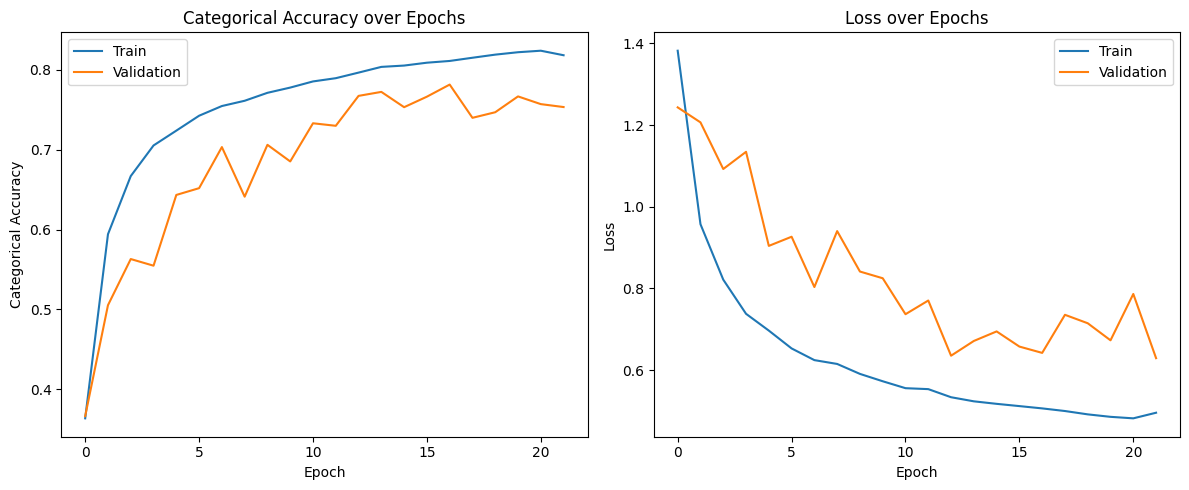

In [ ]:
# Create a single figure with two subplots: Accuracy and Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['categorical_accuracy'], label='Train')
ax1.plot(history.history['val_categorical_accuracy'], label='Validation')
ax1.set_title('Categorical Accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Categorical Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

The above graphs show us the increase in accuray and decrease in loss during training compared to the validation data that was provided. Overtime, those values started to get closer together however they were not perfect. We can also see that past epoch 15 our validation started to stall and slightly worsen. The high fluctuations in the validation indicate that the model was extremely sensitive to the data we gave it.

#### CNN evaluated confusion matrix

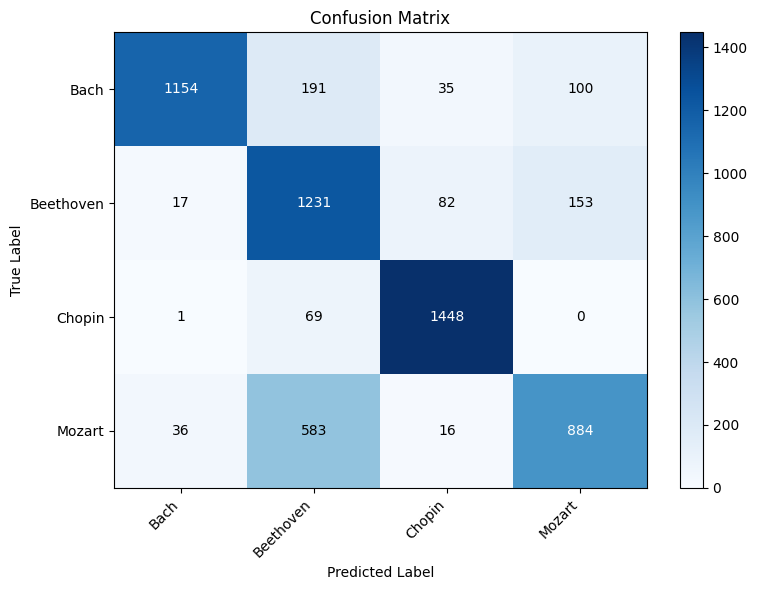

In [ ]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', aspect='auto', cmap='Blues')
plt.colorbar(im, ax=ax)

tick_marks = np.arange(n_classes)
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, f"{cm[i, j]:d}",
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()


The above confusion matrix shows how many instances of each true composer were predicted as each composer.

**Strong Diagonal**  
   - **Bach** → Bach: 1154  
   - **Beethoven** → Beethoven: 1231  
   - **Chopin** → Chopin: 1448  
   - **Mozart** → Mozart:  884  

This strong diagonal tells us that our model did a decent job actually predicting the correct composer, however it struggled for certain composers. Specifically Mozart, Which was inccorectly predictied as Beethoven a number of times! We can also see that our model never Chopin as mozart, and only once for Bach, which is excellent! Meaning our model was able to clearly distinguish those two composers from bach very well.

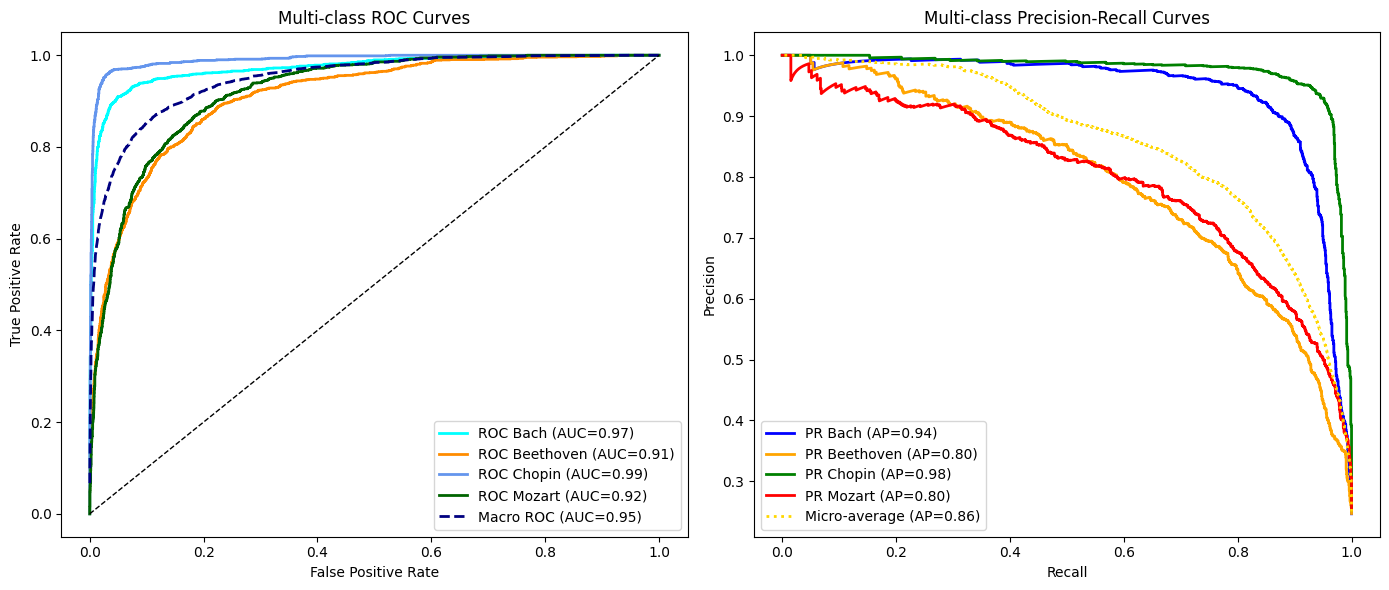

In [ ]:
# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute Precision-Recall for each class
precision = dict()
recall = dict()
avg_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    avg_precision[i] = average_precision_score(y_test[:, i], y_prob[:, i])

# Compute micro-average Precision-Recall
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_prob.ravel())
avg_precision["micro"] = average_precision_score(y_test, y_prob, average="micro")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen'])
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr[i], tpr[i], color=color, lw=2,
              label=f'ROC {classes[i]} (AUC={roc_auc[i]:0.2f})')
ax1.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', lw=2,
          label=f'Macro ROC (AUC={roc_auc["macro"]:0.2f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Multi-class ROC Curves')
ax1.legend(loc='lower right')

# Plot Precision-Recall curves
colors = cycle(['blue', 'orange', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    ax2.plot(recall[i], precision[i], color=color, lw=2,
              label=f'PR {classes[i]} (AP={avg_precision[i]:0.2f})')
ax2.plot(recall["micro"], precision["micro"], color='gold', linestyle=':',
          label=f'Micro-average (AP={avg_precision["micro"]:0.2f})', lw=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Multi-class Precision-Recall Curves')
ax2.legend(loc='lower left')

plt.tight_layout()
plt.show()








The above graphs show the multi class ROC and precision recall curves for each composer.

### ROC

- **Bach (AUC = 0.97)**  
  The aqua curve hugs the top-left corner, indicating very high separability. Bach examples are distinguished from others with few false positives.

- **Beethoven (AUC = 0.91)**  
  The dark orange curve is lower, showing that Beethoven is harder to separate with more overlap with other composers, yielding a slight trade off between sensitivity and specificity.

- **Chopin (AUC = 0.99)**  
  The cornflowerblue curve is almost perfect. Chopin pieces are the easiest for the model to identify, with almost no confusion.

- **Mozart (AUC = 0.92)**  
  The dark green curve is strong but not as extreme as Chopins. Mozart is well separated, though there remains some false positive rate to achieve high recall.

- **Macro-average ROC (AUC = 0.95)**  
  The dashed navy curve averages all four class curves. An AUC of 0.95 indicates excellent overall discriminative ability across composers.

### Percision Vs Recall curves


- **Bach (AP = 0.94)**  
  The solid blue curve stays near the top, which indicates a high precision, for most recall levels. This means our model keeps false alarms low even as it captures more Bach examples.

- **Beethoven (AP = 0.80)**  
  The solid orange curve falls off more quickly, indicating that to capture more Beethoven samples and have a higher recall, our model must tolerate a larger drop in precision.

- **Chopin (AP = 0.98)**  
  The solid green curve is almost flat near precision=1.0, signifying nearly no false positives for any recall level until the extreme end—Chopin remains highly reliable.

- **Mozart (AP = 0.80)**  
  The solid red curve mirrors Beethovens behavior. Mozart classification requires trading off precision to gain recall, suggesting similar difficulty.

- **Micro-average PR (AP = 0.86)**  
  The dotted gold curve pools all classes. An AP of 0.86 reflects the aggregate precision recall balance, weighted by class frequency.


## Comparision report analysis of LSTM models, BiLSTM + Attention models and CNN

Here’s a detailed comparison between the LSTM and BiLSTM + Attention models based on your confusion matrices, performance metrics, and key observations:

**Overall Performance Comparison Table:**

| **Metric**               | **LSTM Model** | **BiLSTM + Attention Model** | **CNN Model** |
|--------------------------|----------------|-------------------------------|---------------|
| **Test Accuracy**        | 85.06%         | 90.38%                        | 78.62%        |
| **Test Loss**            | 0.7187         | 0.2460                        | 0.6195        |
| **Macro Avg Precision**  | 0.85           | 0.90                          | 0.8376        |
| **Macro Avg Recall**     | 0.89           | 0.93                          | 0.6780        |
| **Macro Avg F1-Score**   | 0.86           | 0.91                          | 0.7873        |
| **Weighted Avg F1-Score**| 0.85           | 0.90                          | —             |

**Confusion matrix comparision:**

| **Class**    | **LSTM**             | **BiLSTM + Attention**  | **CNN**                        |
|--------------|----------------------|--------------------------|---------------------------------|
| **Bach**     | 185 / 187 (99%)      | 181 / 187 (97%)          | 1154 / (1154+191+35+100) ≈ 82%  |
| **Beethoven**| 317 / 435 (73%)      | 344 / 435 (79%)          | 1231 / (17+1231+82+153) ≈ 79%   |
| **Chopin**   | 220 / 220 (100%)     | 220 / 220 (100%)         | 1448 / (1+69+1448+0) ≈ 95%      |
| **Mozart**   | 189 / 229 (83%)      | 222 / 229 (97%)          | 884 / (36+583+16+884) ≈ 57%     |


**Major Confusions**

**LSTM**

*	Beethoven had large confusion with Mozart (75), Bach (20), and Chopin (23).

*	Mozart misclassified mainly into Beethoven (30) and Bach (10).

**BiLSTM + Attention**

*	Beethoven confusion reduced but still present with Mozart (48), Bach (20), and Chopin (23).

*	Mozart misclassifications dropped significantly — only 7 total.

**CNN**

*	Strongest performance for Chopin (F1 ≈ 0.93) and Bach (F1 ≈ 0.86).

*	Beethoven moderately good but lower recall (F1 ≈ 0.69).

*	Struggles most with Mozart (F1 ≈ 0.66), often misclassifying into Beethoven.

| **Composer** | **F1 Score** | **Interpretation** |
|--------------|--------------|--------------------|
| **Bach**     | 0.8586       | Strong balance of precision and recall. |
| **Beethoven**| 0.6922       | Moderate — misses more than half of true positives or has notable false positives. |
| **Chopin**   | 0.9345       | Excellent — almost never mislabels Chopin, rarely misses true Chopin pieces. |
| **Mozart**   | 0.6657       | Weakest — confusion with other composers, especially Beethoven. |

Interpretation and Insights

Improvements in BiLSTM + Attention:

*	+5.32% Test Accuracy over LSTM, indicating better sequence modeling.

*	Test Loss reduced by ~65% — stronger generalization.

*	Mozart Recall improved from 0.83 → 0.97, solving the biggest LSTM weakness.

*	Higher Recall for Beethoven (0.73 → 0.79) and maintained perfect recall for Chopin.

*	Precision-Recall curves show sharper separation for Mozart, Beethoven.

CNN Performance Notes:

*	CNN shows competitive precision (0.84 macro) but lower recall (0.68 macro), indicating more false negatives.

*	Strongest on well-differentiated styles (Chopin, Bach) but weaker on overlapping styles (Mozart, Beethoven).

*	Lower overall accuracy (78.62%) than LSTM and BiLSTM + Attention, likely due to CNN’s limitations in long-term temporal modeling without recurrent layers.


**Why BiLSTM + Attention Outperforms LSTM:**

| **Reason**                     | **Explanation**                                                                                                     |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------|
| **Bidirectional Context**       | Processes sequences from both past and future, enabling richer temporal understanding — crucial for capturing motifs and harmonic progression. |
| **Attention Mechanism**         | Focuses on the most important timesteps, improving recognition of subtle composer-specific patterns like cadence and ornamentation. |
| **Better Generalization**       | Validation accuracy is closer to training accuracy, showing controlled overfitting with the selected dropout rate and batch size. |
| **Improved Mozart Disambiguation** | Mozart’s style, which overlaps with others, is better separated by highlighting distinctive patterns through attention. |


***Conclusion:***

The BiLSTM + Attention model delivers stronger, more stable, and more precise classification than the LSTM model, especially for challenging cases like Mozart.

The bidirectional flow enables the model to capture full temporal context, while attention selectively focuses on the most informative notes. This combination leads to substantial improvements in recall, precision, and overall accuracy across the board.

CNN achieves high precision and excels with clearly distinct composer styles but underperforms on classes with overlapping characteristics, likely due to its limited ability to capture long-term temporal dependencies in symbolic music.


***Future Recommendations:***

1. Ensemble Learning: Combine predictions from multiple architectures (e.g., LSTM, BiLSTM, Transformer-based models) to improve robustness and reduce bias toward certain classes.

2.	Transformer-Based Models

•	Experiment with Music Transformer or Performer architectures, which can capture long-term dependencies better than RNN-based models.

3.	Advanced Data Augmentation

•	Introduce tempo variation, pitch shifting, and rhythmic perturbations in a controlled manner to improve generalization.

4.	Feature Enrichment

•	Add higher-level musical features such as harmonic intervals, key signatures, rhythmic complexity scores, and motif repetition counts.

5.	Class Imbalance Handling

•	Use focal loss or cost-sensitive learning to improve performance for underrepresented classes without oversampling or undersampling.

6.	Regularization Enhancements

•	Apply techniques like layer normalization, weight decay (L2), or stochastic depth to further control overfitting.

7.	Hyperparameter Optimization

•	Run Bayesian optimization or genetic algorithms for fine-tuning parameters like units, dropout rates, learning rate schedules, and attention dimensions.

8.	Multi-Modal Integration

•	Combine symbolic features (MIDI) with audio spectrograms for richer representation learning.

9.	Model Interpretability

•	Use SHAP or Integrated Gradients to visualize which notes or patterns contribute most to classification decisions.

10.	Deployment & Real-Time Prediction

•	Optimize the best model for low-latency inference to run in real-time composer identification applications.






